# BA820 — Milestone 3: Integrated Analysis
### Team Analysis — *Alone* TV Show Dataset

---

## Executive Summary

This notebook integrates individual Milestone 2 analyses into a single, coherent pipeline. We combine episode-level clustering (IMDb ratings, vote counts, viewership), tap-out narrative analysis, and survival item association rules. The integration reveals how different approaches—rating-based segmentation, viewership-based clustering, and NLP theme discovery—complement each other to understand the *Alone* TV show data.


## Business and Research Problem

The *Alone* TV show datasets (episodes, seasons, survivalists, loadouts) support multiple analytical angles. Our integrated analysis addresses:

| Analytical Focus | Research Question |
|------------------|-------------------|
| Episode & Season Clustering | How do episodes and seasons segment by IMDb ratings, vote counts, and viewership? |
| Episode Segmentation with Viewership | Can we meaningfully segment episodes using viewers, IMDb ratings, and vote counts together? |
| Tap-Out Narratives | What themes exist in contestants' exit reasons? |
| Survival Item Selection | Which items are chosen together most frequently? |

The synergy comes from shared preprocessing, complementary methods, and cross-validation of findings.


---
## A. Data Overview and Preparation

All four datasets are loaded and cleaned once here. Every subsequent section references these shared dataframes.


In [ ]:
import pandas as pd
import numpy as np

#all the csv's imported
episodes_url = "https://drive.google.com/uc?export=download&id=1Q2s1TZAl1epx_-hi8yXWQv12UJGt_LYe"
episodes_data = pd.read_csv(episodes_url)
loadouts_url = "https://drive.google.com/uc?export=download&id=1xym94LM-MIvEWI-IauIJViR4mXaqMiB0"
loadouts_data = pd.read_csv(loadouts_url)
seasons_url = "https://drive.google.com/uc?export=download&id=1M1cEpgPXD1PTLywN2JD7Dn8-QEWcUfWQ"
seasons_data = pd.read_csv(seasons_url)
survivalists_url = "https://drive.google.com/uc?export=download&id=1L600G_6QA1XVZGKl3Ky5AC9FWC4Uu3po"
survivalists_data = pd.read_csv(survivalists_url)

# the view of the first few rows
print(episodes_data.head())
print(loadouts_data.head())
print(seasons_data.head())
print(survivalists_data.head())

  version  season  episode_number_overall  episode               title  \
0      US       1                       1        1    And So It Begins   
1      US       1                       2        2     Of Wolf and Man   
2      US       1                       3        3  The Talons of Fear   
3      US       1                       4        4             Stalked   
4      US       1                       5        5       Winds of Hell   

     air_date  viewers                                              quote  \
0  2015-06-18    1.582  I went to the woods because I wished to live d...   
1  2015-06-25    1.697  If you live among wolves you have to act like ...   
2  2015-07-02    1.864  Extinction is the rule. Survival is the except...   
3  2015-07-09    2.082  Hunger, love, pain, fear are some of those inn...   
4  2015-07-16    2.082    The strong survive, but the courageous triumph.   

                author  imdb_rating  n_ratings  
0  Henry David Thoreau          7.5      13

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# all the datasets collected
datasets = {
    "episodes_data": episodes_data,
    "loadouts_data": loadouts_data,
    "seasons_data": seasons_data,
    "survivalists_data": survivalists_data,
}

for name, df in datasets.items():
    print(f"\n{'=' * 80}")
    print(f"DATASET: {name}")
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nPreview (first 5 rows):")
    display(df.head())
    print("\nData types:")
    print(df.dtypes)
    print("\nBasic numeric summary (describe):")
    display(df.describe(include=[np.number]).T)
    print("\nBasic categorical summary (top-level describe):")
    display(df.describe(include=["object"]).T)


DATASET: episodes_data
Shape: 98 rows x 11 columns

Column names:
['version', 'season', 'episode_number_overall', 'episode', 'title', 'air_date', 'viewers', 'quote', 'author', 'imdb_rating', 'n_ratings']

Preview (first 5 rows):


,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0
3,US,1,4,4,Stalked,2015-07-09,2.082,"Hunger, love, pain, fear are some of those inn...",Albert Einstein,7.7,104.0
4,US,1,5,5,Winds of Hell,2015-07-16,2.082,"The strong survive, but the courageous triumph.",Michael Scott,7.6,99.0



Data types:
version                    object
season                      int64
episode_number_overall      int64
episode                     int64
title                      object
air_date                   object
viewers                   float64
quote                      object
author                     object
imdb_rating               float64
n_ratings                 float64
dtype: object

Basic numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
season,98.0,4.969388,2.633856,1.000,3.000,5.000,7.0000,9.000
episode_number_overall,98.0,50.163265,29.039857,1.000,25.250,50.500,74.7500,100.000
episode,98.0,5.979592,3.210741,1.000,3.000,6.000,9.0000,13.000
viewers,83.0,1.527880,0.270149,0.989,1.344,1.507,1.6875,2.375
imdb_rating,93.0,7.821505,0.365302,6.900,7.600,7.800,8.1000,8.800
n_ratings,93.0,62.924731,20.081484,5.000,48.000,63.000,68.0000,135.000



Basic categorical summary (top-level describe):


,count,unique,top,freq
version,98,1,US,98
title,98,98,And So It Begins,1
air_date,98,97,2016-07-14,2
quote,98,96,The very basic core of a man's living spirit i...,2
author,98,84,John Muir,4



DATASET: loadouts_data
Shape: 940 rows x 6 columns

Column names:
['version', 'season', 'name', 'item_number', 'item_detailed', 'item']

Preview (first 5 rows):


,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag
3,US,1,Alan Kay,4,Large 2-quart pot,Pot
4,US,1,Alan Kay,5,Ferro rod,Ferro rod



Data types:
version          object
season            int64
name             object
item_number       int64
item_detailed    object
item             object
dtype: object

Basic numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
season,940.0,4.957447,2.535855,1.0,3.0,5.0,7.0,9.0
item_number,940.0,5.500000,2.873810,1.0,3.0,5.5,8.0,10.0



Basic categorical summary (top-level describe):


,count,unique,top,freq
version,940,1,US,940
name,940,84,Nicole Apelian,20
item_detailed,940,198,Ferro rod,66
item,940,27,Pot,92



DATASET: seasons_data
Shape: 9 rows x 8 columns

Column names:
['version', 'season', 'location', 'country', 'n_survivors', 'lat', 'lon', 'date_drop_off']

Preview (first 5 rows):


,version,season,location,country,n_survivors,lat,lon,date_drop_off
0,US,1,Quatsino,Canada,10,50.72444,-127.498056,NaN
1,US,2,Quatsino,Canada,10,50.72444,-127.498056,NaN
2,US,3,Patagonia,Argentina,10,-41.00000,-68.000000,NaN
3,US,4,Quatsino,Canada,14,50.72444,-127.498056,NaN
4,US,5,Selenge Province,Mongolia,10,49.75000,106.500000,NaN



Data types:
version           object
season             int64
location          object
country           object
n_survivors        int64
lat              float64
lon              float64
date_drop_off     object
dtype: object

Basic numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
season,9.0,5.000000,2.738613,1.000000,3.000000,5.000000,7.00,9.000000
n_survivors,9.0,10.444444,1.333333,10.000000,10.000000,10.000000,10.00,14.000000
lat,9.0,43.872283,32.218259,-41.000000,50.724440,50.724440,59.66,61.500278
lon,9.0,-84.480000,75.840033,-127.498056,-127.498056,-114.001111,-68.00,106.500000



Basic categorical summary (top-level describe):


,count,unique,top,freq
version,9,1,US,9
location,9,7,Quatsino,2
country,9,3,Canada,7
date_drop_off,3,3,2019-09-18,1



DATASET: survivalists_data
Shape: 94 rows x 16 columns

Column names:
['season', 'name', 'age', 'gender', 'city', 'state', 'country', 'result', 'days_lasted', 'medically_evacuated', 'reason_tapped_out', 'reason_category', 'team', 'day_linked_up', 'profession', 'url']

Preview (first 5 rows):


,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell
3,1,Lucas Miller,32,Male,Quasqueton,Iowa,United States,4,39,False,Felt content with what he had done,Family / personal,NaN,NaN,Survivalist and Wildlife Therapist/Natural Hea...,lucas-miller
4,1,Dustin Feher,37,Male,Pittsburgh,Pennsylvania,United States,5,8,False,Fear of storm,Family / personal,NaN,NaN,Carpenter,dustin-feher



Data types:
season                   int64
name                    object
age                      int64
gender                  object
city                    object
state                   object
country                 object
result                   int64
days_lasted              int64
medically_evacuated       bool
reason_tapped_out       object
reason_category         object
team                    object
day_linked_up          float64
profession              object
url                     object
dtype: object

Basic numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
season,94.0,4.957447,2.548096,1.0,3.00,5.0,7.00,9.0
age,94.0,37.936170,8.844910,19.0,31.00,38.5,44.00,61.0
result,94.0,5.276596,2.826161,1.0,3.00,5.0,7.75,10.0
days_lasted,94.0,39.042553,27.849409,0.0,10.50,39.5,63.75,100.0
day_linked_up,8.0,9.000000,0.755929,8.0,8.75,9.0,9.25,10.0



Basic categorical summary (top-level describe):


,count,unique,top,freq
name,94,84,Sam Larson,2
gender,94,2,Male,74
city,94,77,Salt Lake City,3
state,93,40,Alaska,11
country,94,4,United States,79
reason_tapped_out,84,61,Starvation,7
reason_category,84,3,Medical / health,45
team,14,7,Baird (brothers),2
profession,94,80,Carpenter,4
url,94,87,brook-and-dave-whipple,2


**Interpretation:** The four datasets—episodes, loadouts, seasons, survivalists—are loaded and previewed. Episodes contain viewership, IMDb ratings, and metadata; loadouts capture item selections per contestant; seasons describe locations; survivalists include demographics and tap-out reasons. This shared foundation enables all downstream sections.


### A.1 Data Cleaning and Standardization

To make downstream analysis easier and more consistent, we:

- Standardize column names to snake_case.
- Create working copies so raw dataframes remain unchanged.
- Convert date-like columns to datetime where applicable.
- Check and summarize missing values for each dataset.


In [ ]:
# Create cleaned working copies of the datasets
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy of df with standardized, snake_case column names."""
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

# Working copies with standardized column names
episodes = standardize_columns(episodes_data)
loadouts = standardize_columns(loadouts_data)
seasons = standardize_columns(seasons_data)
survivalists = standardize_columns(survivalists_data)

# Convert date-like columns to datetime if present
if "air_date" in episodes.columns:
    episodes["air_date"] = pd.to_datetime(episodes["air_date"], errors="coerce")
if "date_drop_off" in seasons.columns:
    seasons["date_drop_off"] = pd.to_datetime(seasons["date_drop_off"], errors="coerce")

# Compute missing value summary
def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    missing_count = df.isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    return pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})

for name, df in {
    "episodes": episodes,
    "loadouts": loadouts,
    "seasons": seasons,
    "survivalists": survivalists,
}.items():
    print(f"\n{'-' * 60}")
    print(f"Missing values for {name}:")
    display(missing_summary(df).sort_values("missing_count", ascending=False))


------------------------------------------------------------
Missing values for episodes:


,missing_count,missing_pct
viewers,15,15.306122
n_ratings,5,5.102041
imdb_rating,5,5.102041
episode_number_overall,0,0.000000
season,0,0.000000
version,0,0.000000
episode,0,0.000000
air_date,0,0.000000
title,0,0.000000
author,0,0.000000



------------------------------------------------------------
Missing values for loadouts:


,missing_count,missing_pct
version,0,0.0
season,0,0.0
name,0,0.0
item_number,0,0.0
item_detailed,0,0.0
item,0,0.0



------------------------------------------------------------
Missing values for seasons:


,missing_count,missing_pct
date_drop_off,6,66.666667
version,0,0.000000
location,0,0.000000
season,0,0.000000
country,0,0.000000
n_survivors,0,0.000000
lat,0,0.000000
lon,0,0.000000



------------------------------------------------------------
Missing values for survivalists:


,missing_count,missing_pct
day_linked_up,86,91.489362
team,80,85.106383
reason_tapped_out,10,10.638298
reason_category,10,10.638298
state,1,1.063830
season,0,0.000000
age,0,0.000000
name,0,0.000000
result,0,0.000000
country,0,0.000000


### A.2 Filtered Episode Subset (Non-Missing IMDb Ratings)

For IMDb-focused analyses, we create `episodes_r` by dropping rows where `imdb_rating` is null.


In [ ]:
# Checking for IMDb Ratings with missing values

episodes_r = episodes_data.dropna(subset=["imdb_rating"]).copy()
print("Rows with non-missing imdb_rating:", len(episodes_r), "out of", len(episodes_data))

Rows with non-missing imdb_rating: 93 out of 98


### A.3 Data Quality Checks

We verify missingness and duplicates to ensure downstream analyses use clean inputs.


In [ ]:
# Missing count for each column in episode_data

key_cols = ["imdb_rating", "n_ratings", "viewers", "air_date", "title", "season", "episode"]
missing = episodes_data[key_cols].isna().sum().to_frame(name="missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(episodes_data)).round(4)

display(missing)

,missing_count,missing_pct
imdb_rating,5,0.0510
n_ratings,5,0.0510
viewers,15,0.1531
air_date,0,0.0000
title,0,0.0000
season,0,0.0000
episode,0,0.0000


In [ ]:
#Checking for duplicates

dup_mask = episodes_data.duplicated(subset=["season", "episode"], keep=False)
dups = episodes_data.loc[dup_mask, ["season", "episode", "title", "air_date", "imdb_rating"]]

print("Duplicate (season, episode) rows:", dups.shape[0])
if dups.shape[0] > 0:
    display(dups.sort_values(["season", "episode"]))

Duplicate (season, episode) rows: 0


---
## B. Exploratory Data Analysis

This section provides a broad exploratory overview of all four datasets.


### B.1 Univariate Exploration of Key Variables

We summarize numeric and categorical variables and visualize distributions to identify skewness, outliers, and typical ranges.



Seasons: numeric variable distributions


<Figure size 1800x1000 with 0 Axes>

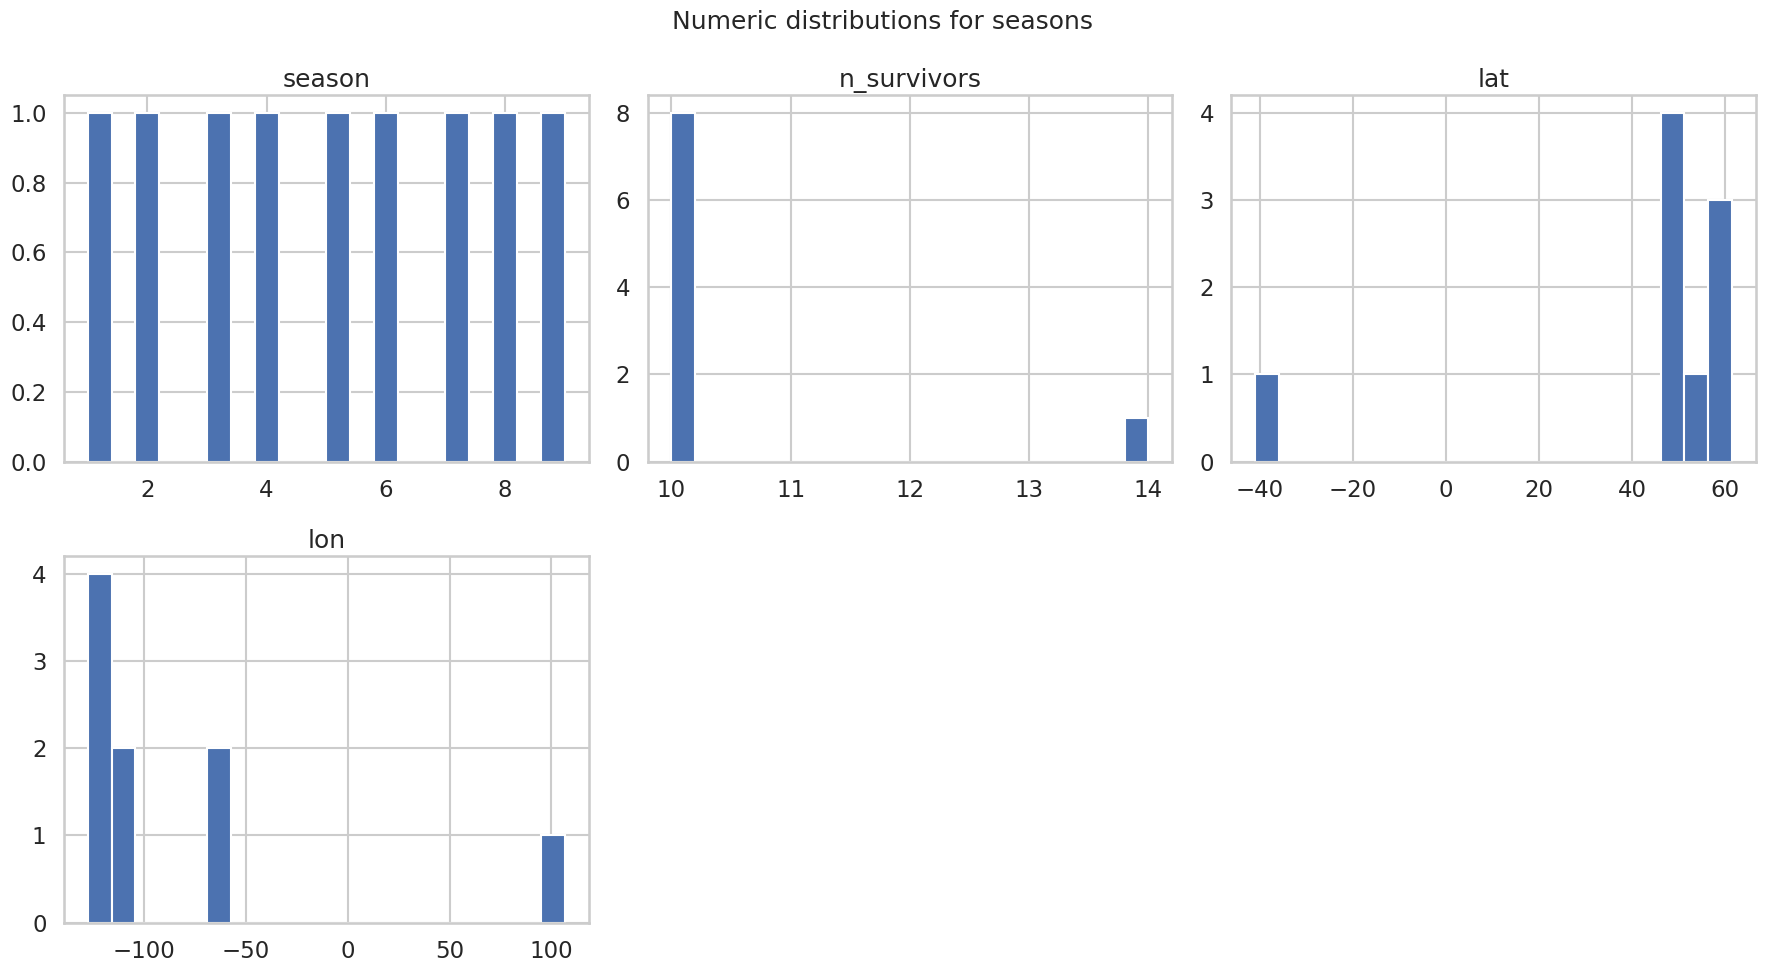

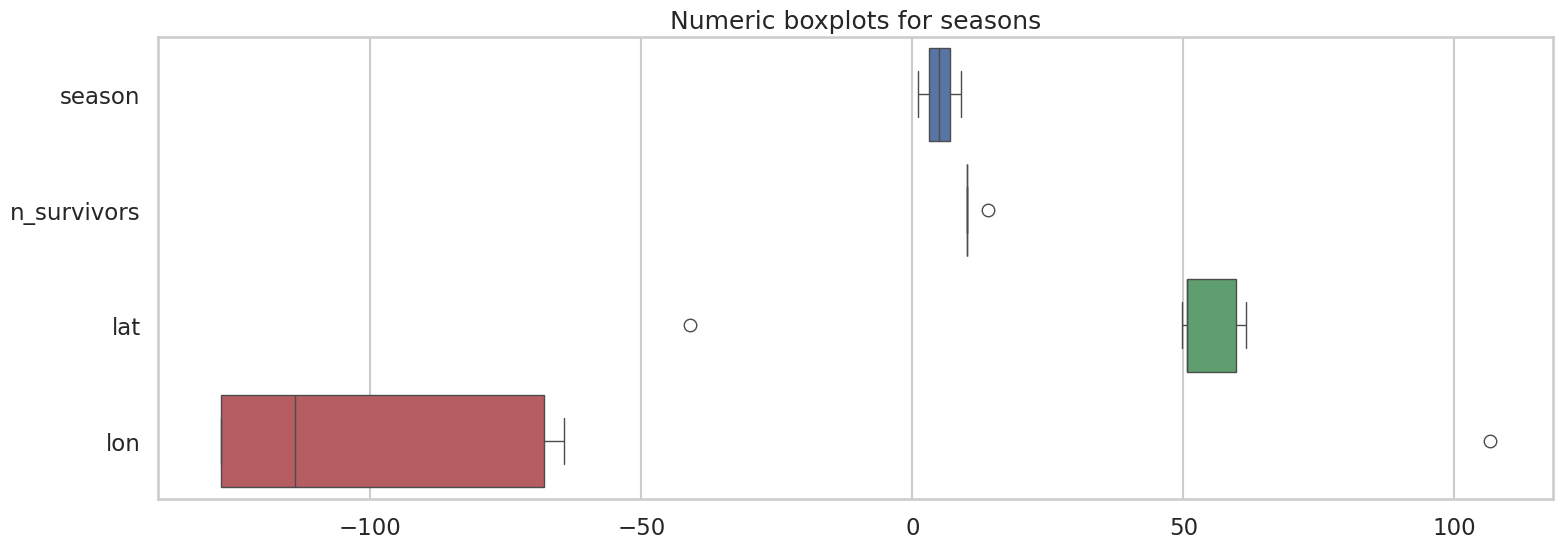


Seasons: top values for 'location'


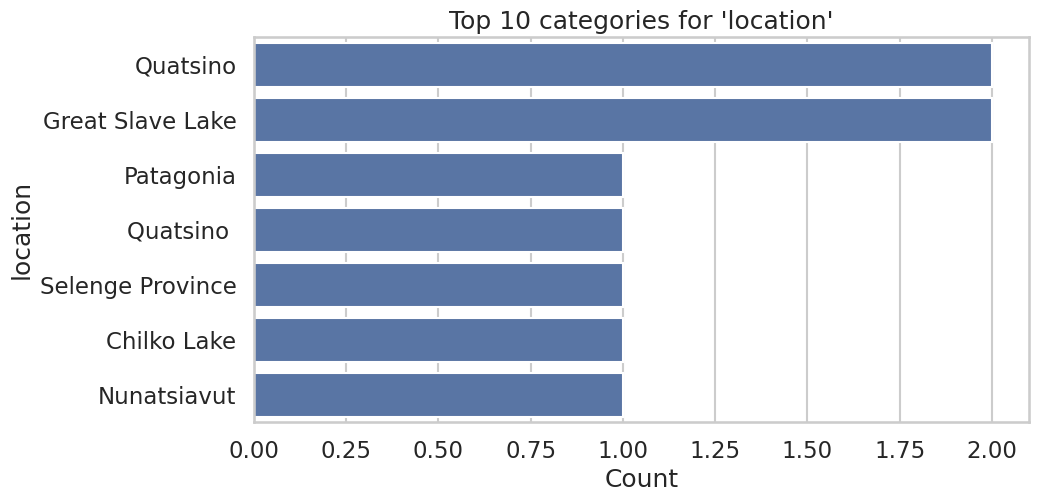


Seasons: top values for 'country'


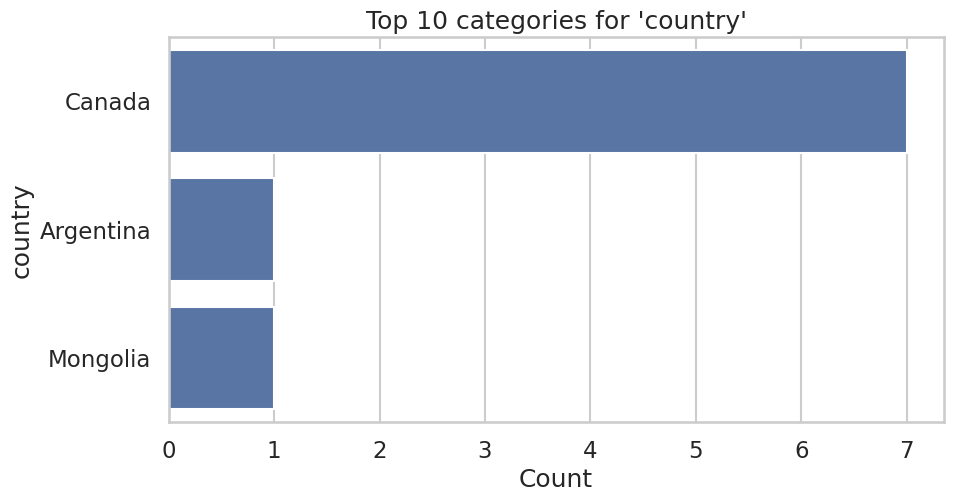


Survivalists: numeric variable distributions


<Figure size 1800x1000 with 0 Axes>

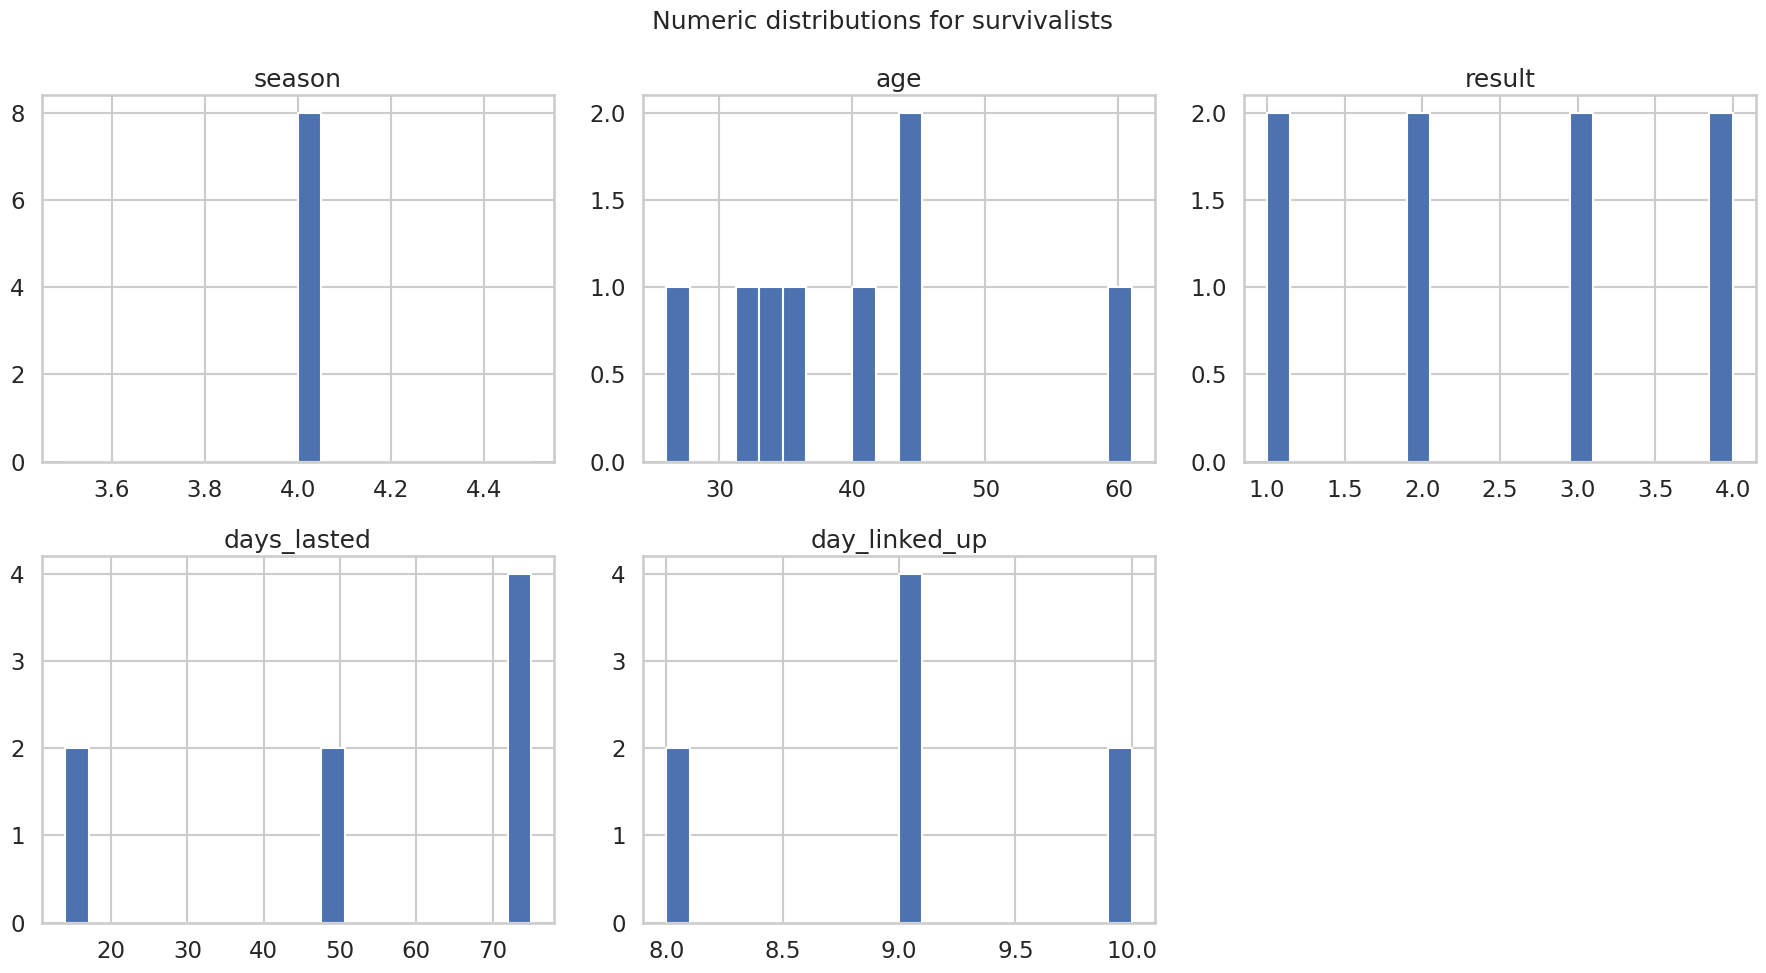

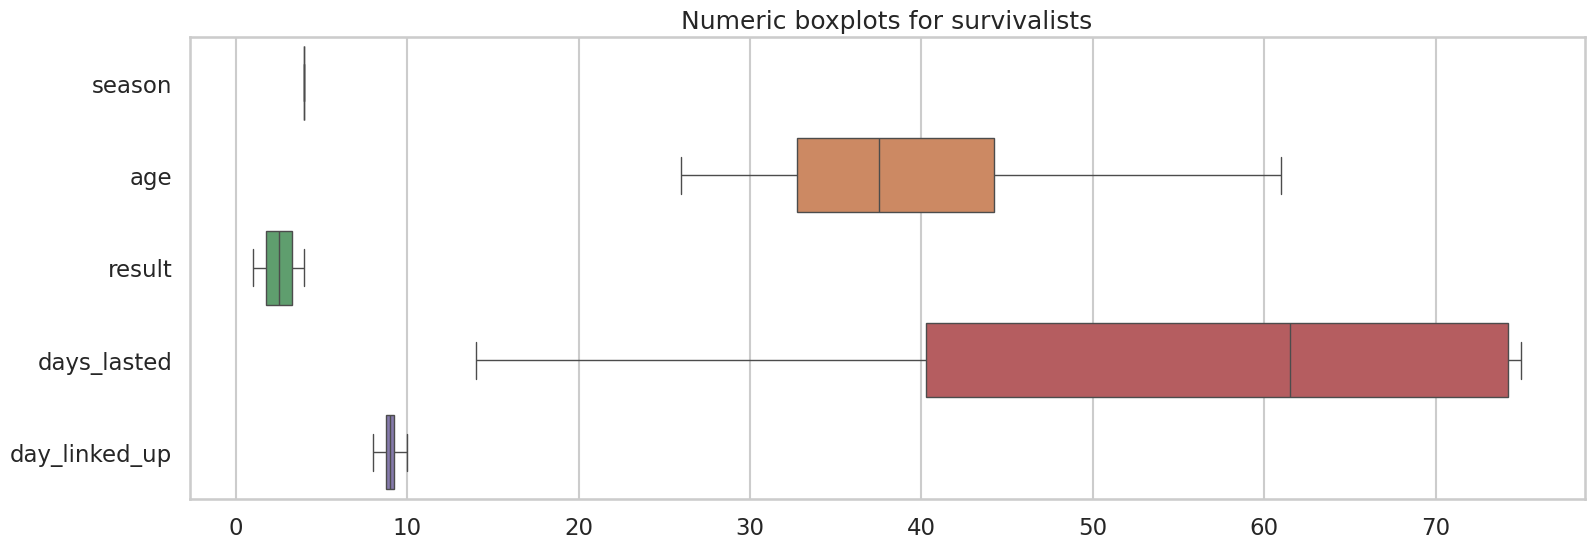


Survivalists: top values for 'gender'


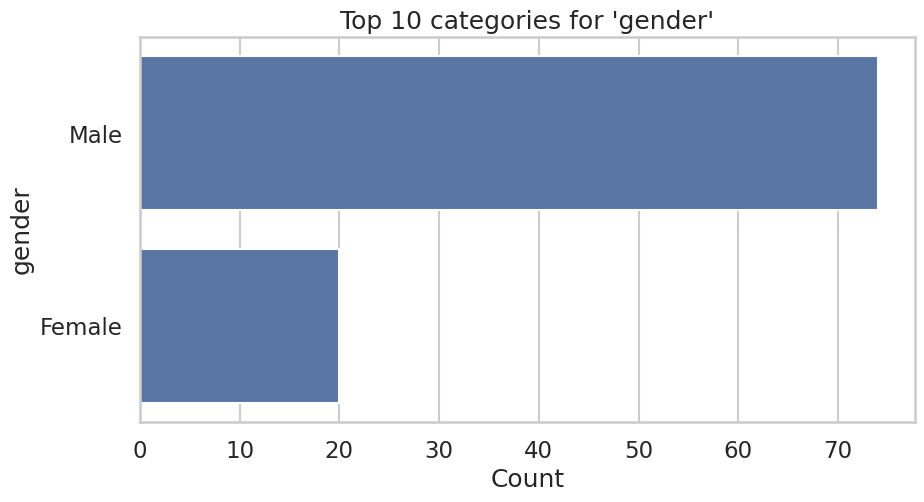


Survivalists: top values for 'reason_category'


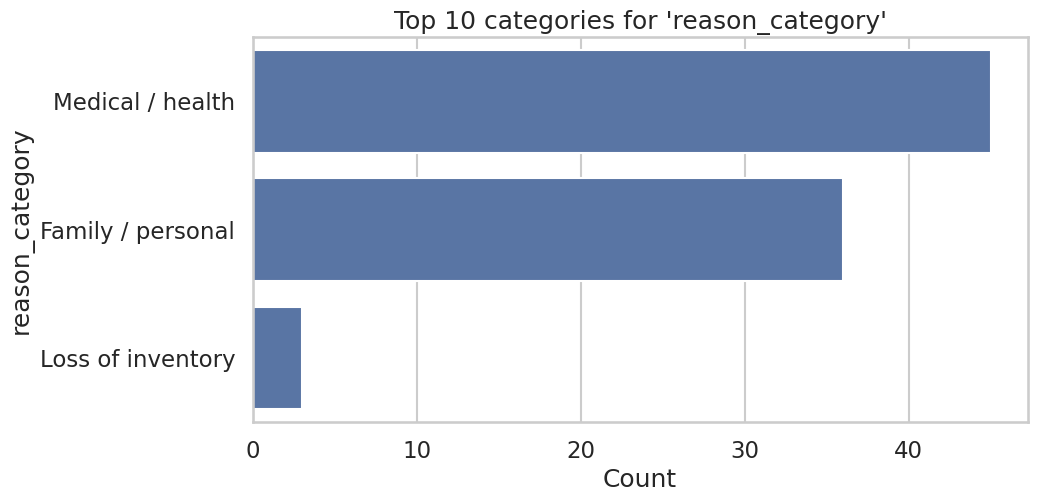


Survivalists: top values for 'result'


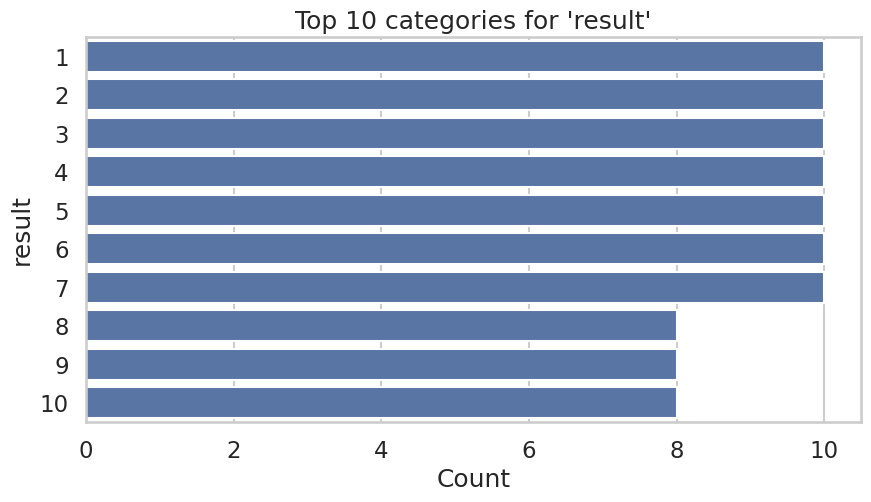


Loadouts: most frequently chosen items

Loadouts: top values for 'item'


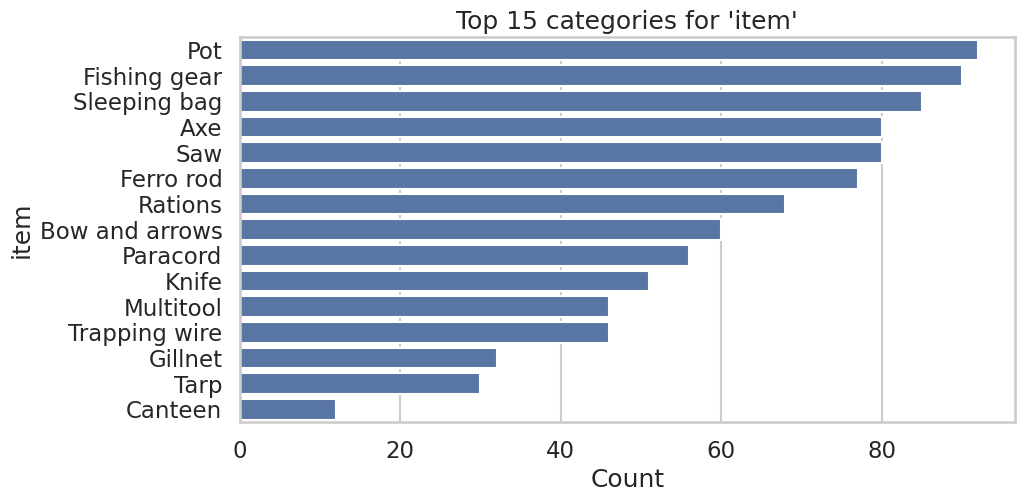


Loadouts: top values for 'item_detailed'


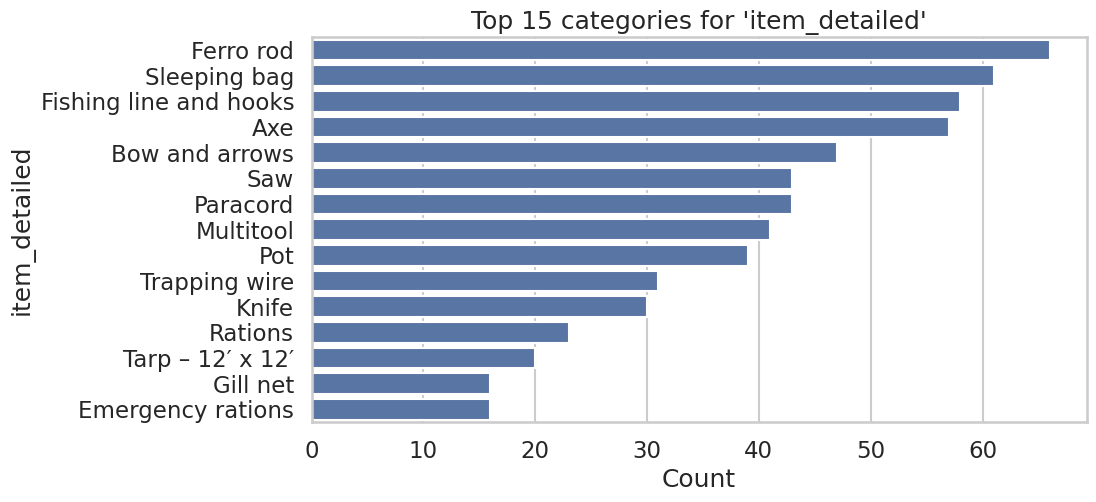


Loadouts: top values for 'name'


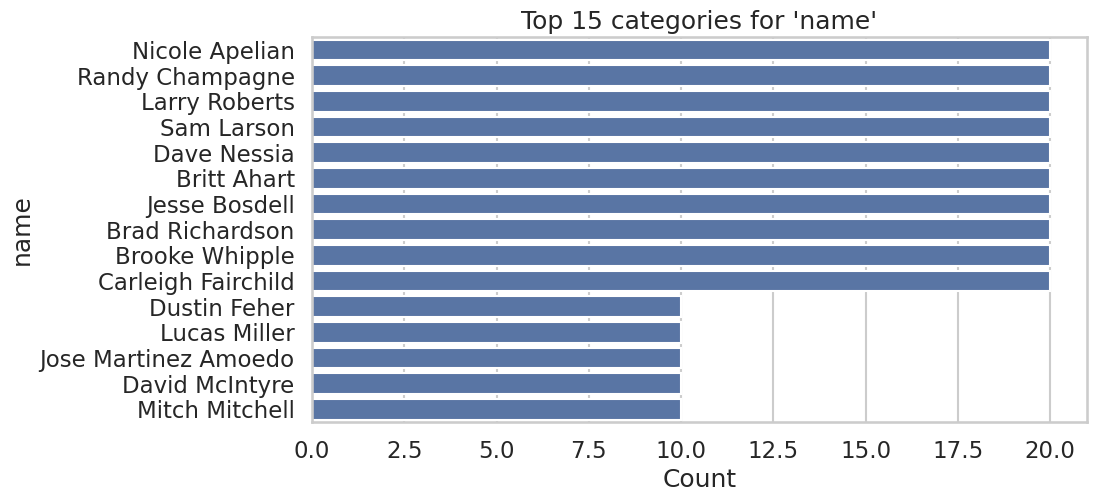

In [ ]:
# Univariate plots
def plot_numeric_distributions(df: pd.DataFrame, title: str):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) == 0:
        print(f"No numeric columns found for {title}.")
        return

    df_numeric = df[numeric_cols].dropna()

    plt.figure(figsize=(18, 10))
    df_numeric.hist(bins=20, figsize=(18, 10), layout=(int(np.ceil(len(numeric_cols) / 3)), 3))
    plt.suptitle(f"Numeric distributions for {title}", fontsize=18)
    plt.tight_layout()
    plt.show()

    # Boxplots for detecting outliers
    plt.figure(figsize=(18, 6))
    sns.boxplot(data=df_numeric, orient="h")
    plt.title(f"Numeric boxplots for {title}")
    plt.show()


def plot_top_categories(df: pd.DataFrame, column: str, top_n: int = 10):
    counts = df[column].value_counts().head(top_n)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.values, y=counts.index, orient="h")
    plt.title(f"Top {top_n} categories for '{column}'")
    plt.xlabel("Count")
    plt.ylabel(column)
    plt.show()

# Seasons: distributions by location and country
print("\nSeasons: numeric variable distributions")
plot_numeric_distributions(seasons, "seasons")

for col in ["location", "country"]:
    if col in seasons.columns:
        print(f"\nSeasons: top values for '{col}'")
        plot_top_categories(seasons, col, top_n=10)

# Survivalists: age, days lasted, gender, and reasons for tapping out
print("\nSurvivalists: numeric variable distributions")
plot_numeric_distributions(survivalists, "survivalists")

for col in ["gender", "reason_category", "result"]:
    if col in survivalists.columns:
        print(f"\nSurvivalists: top values for '{col}'")
        plot_top_categories(survivalists, col, top_n=10)

# Loadouts: most common items selected
print("\nLoadouts: most frequently chosen items")
for col in ["item", "item_detailed", "name"]:
    if col in loadouts.columns:
        print(f"\nLoadouts: top values for '{col}'")
        plot_top_categories(loadouts, col, top_n=15)

### B.2 Relationships Within Datasets: Correlation Analysis

We explore bivariate relationships and correlations among numeric variables. This informs feature selection for clustering and identifies potential redundancy.


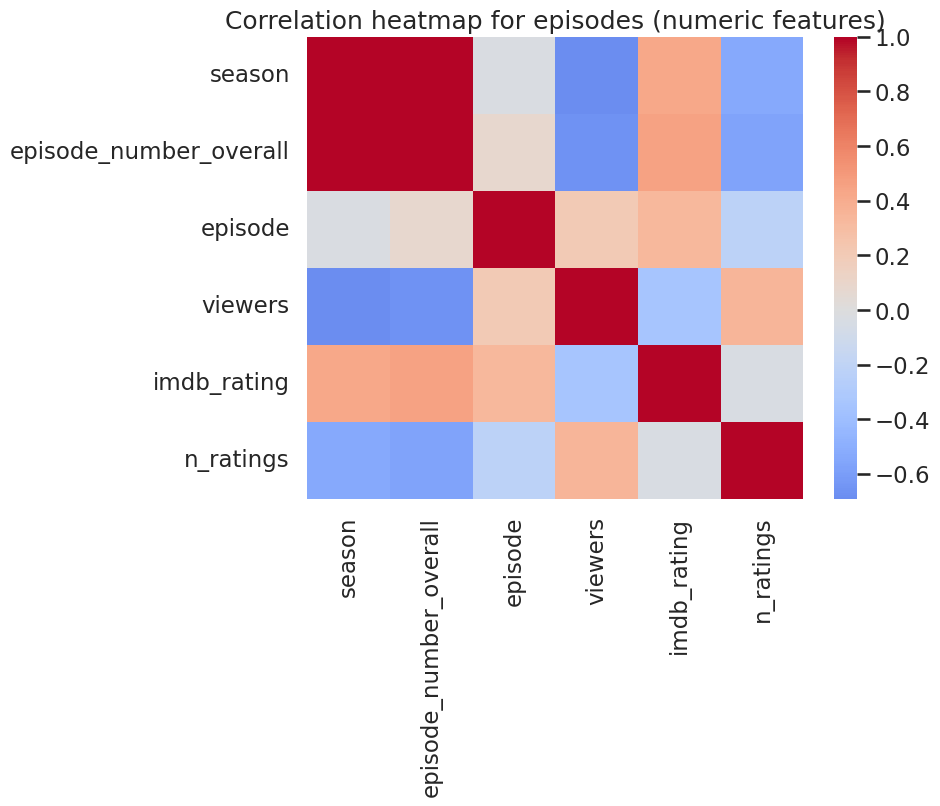

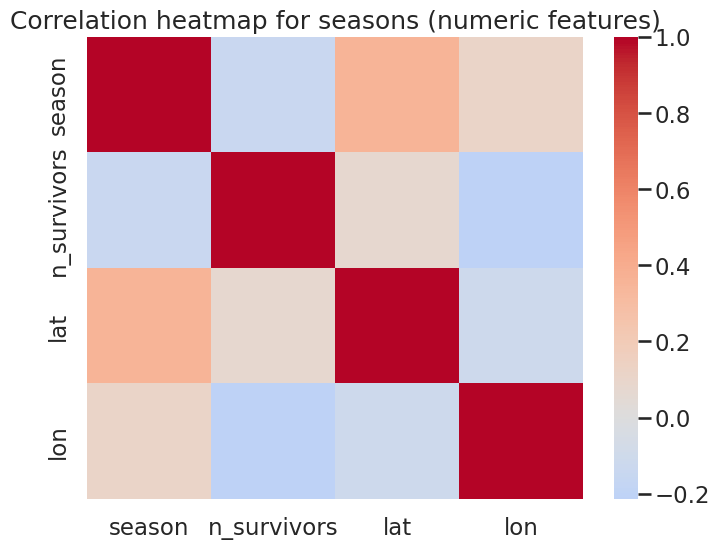

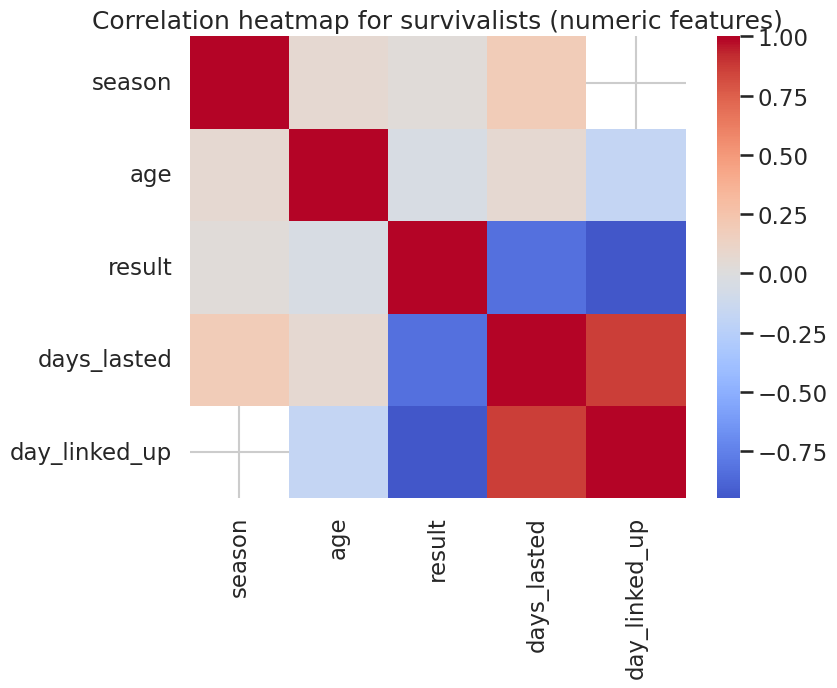

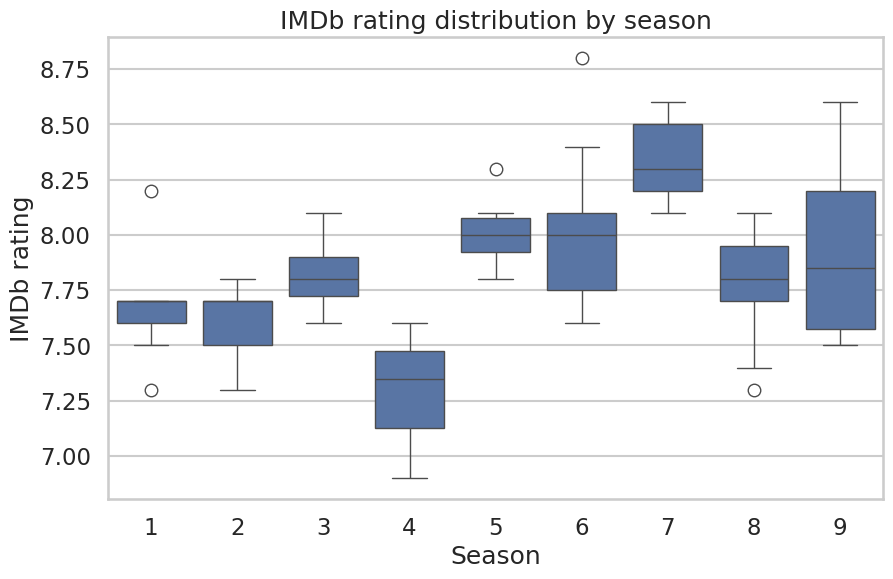

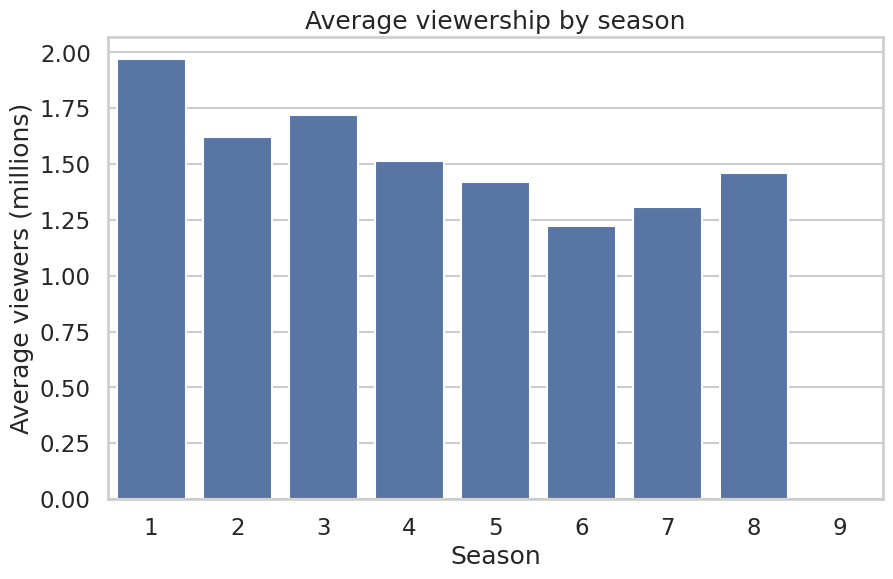

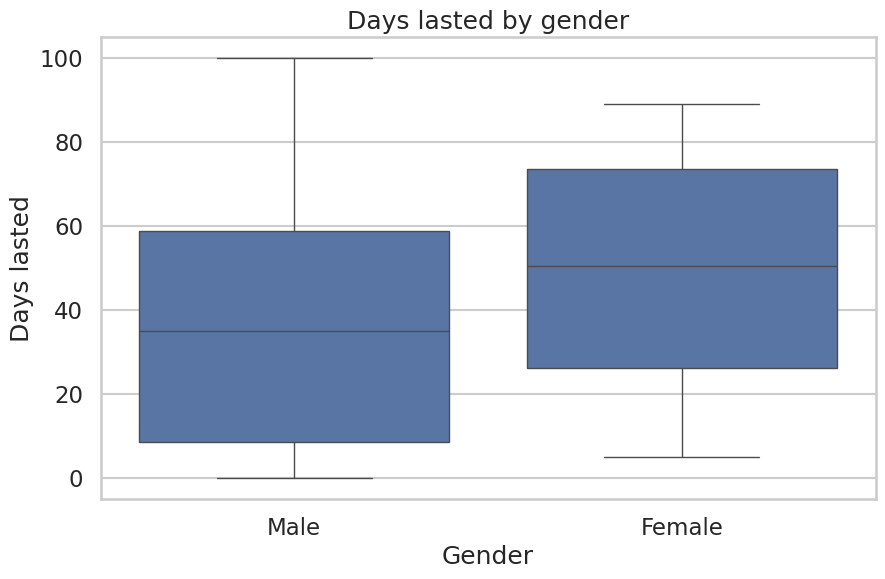

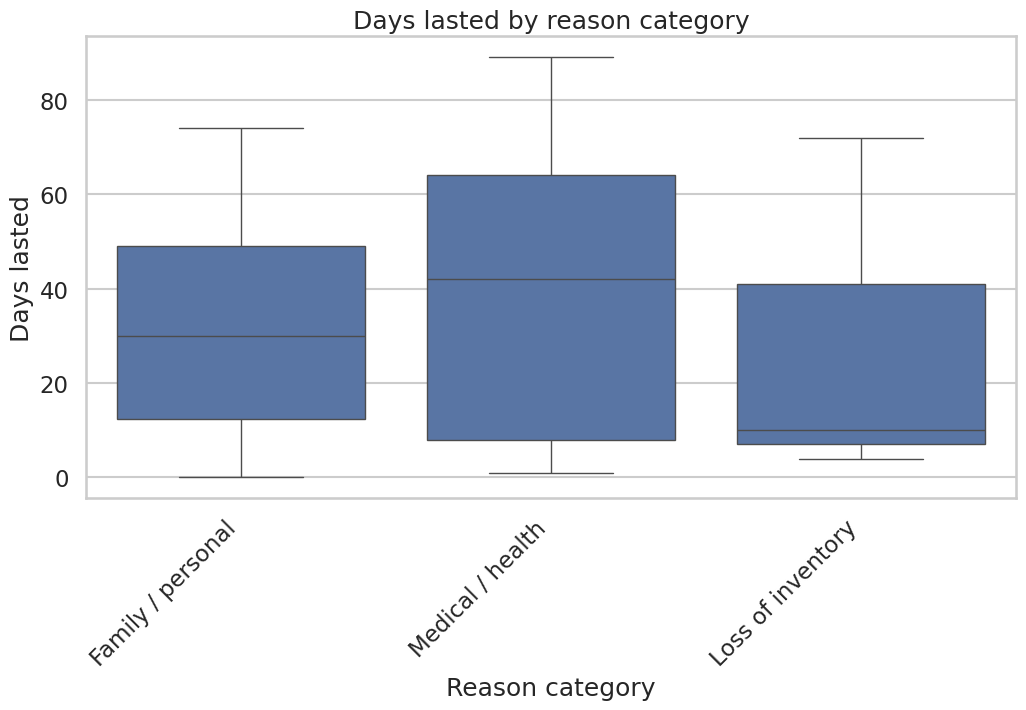

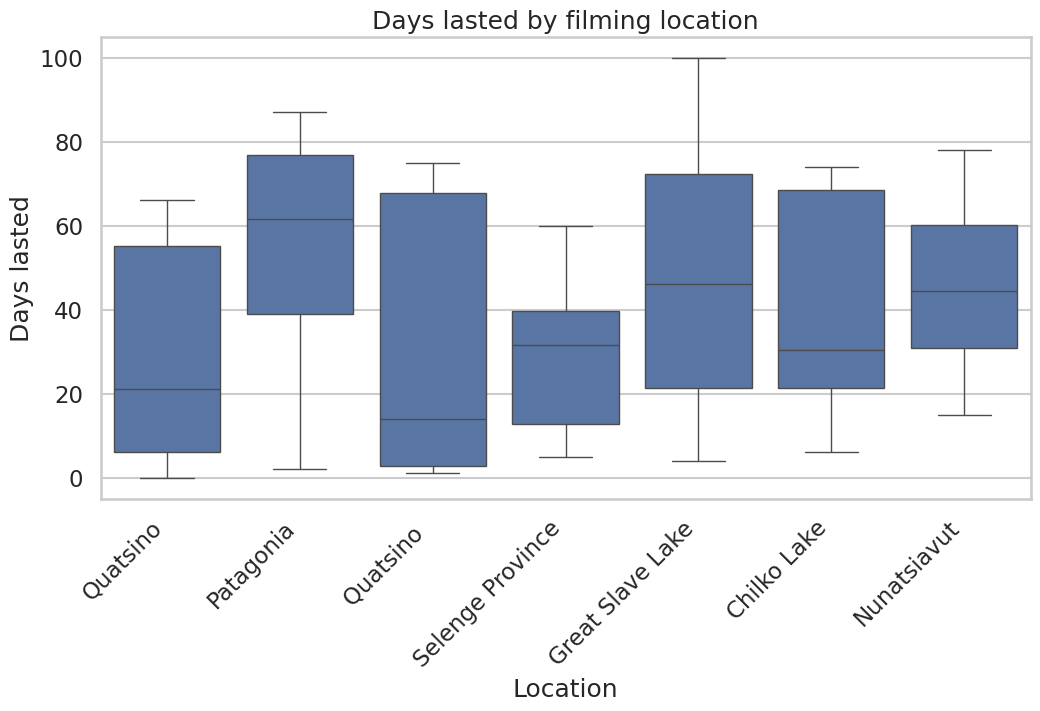


Average days lasted by item (top 15 items):


,days_lasted
item,
Slingshot,50.000000
Soap,49.000000
Trapping wire,48.652174
Frying pan,45.666667
Paracord,43.196429
Hammock,43.000000
Multitool,42.043478
Gillnet,40.812500
Bow and arrows,40.466667



Item frequencies by result (winner vs. others), top 10 items:


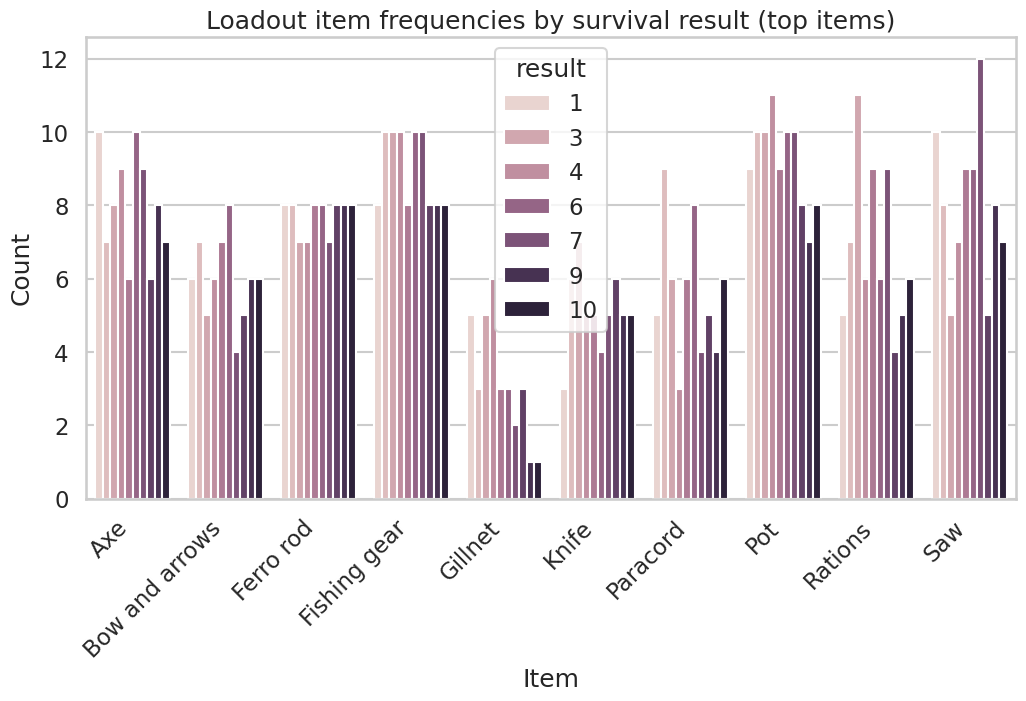

In [ ]:
# Correlations within each dataset (numeric variables only)

for name, df in {
    "episodes": episodes,
    "seasons": seasons,
    "survivalists": survivalists,
}.items():
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) < 2:
        continue

    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(f"Correlation heatmap for {name} (numeric features)")
    plt.show()

# Episodes: ratings and viewers by season
if {"season", "imdb_rating"}.issubset(episodes.columns):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=episodes, x="season", y="imdb_rating")
    plt.title("IMDb rating distribution by season")
    plt.xlabel("Season")
    plt.ylabel("IMDb rating")
    plt.show()

if {"season", "viewers"}.issubset(episodes.columns):
    season_viewership = episodes.groupby("season")["viewers"].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=season_viewership, x="season", y="viewers")
    plt.title("Average viewership by season")
    plt.xlabel("Season")
    plt.ylabel("Average viewers (millions)")
    plt.show()

# Survivalists: days lasted by gender and tap-out reason
if {"gender", "days_lasted"}.issubset(survivalists.columns):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=survivalists, x="gender", y="days_lasted")
    plt.title("Days lasted by gender")
    plt.xlabel("Gender")
    plt.ylabel("Days lasted")
    plt.show()

if {"reason_category", "days_lasted"}.issubset(survivalists.columns):
    plt.figure(figsize=(12, 6))
    top_reasons = survivalists["reason_category"].value_counts().index[:8]
    subs = survivalists[survivalists["reason_category"].isin(top_reasons)]
    sns.boxplot(data=subs, x="reason_category", y="days_lasted")
    plt.title("Days lasted by reason category")
    plt.xlabel("Reason category")
    plt.ylabel("Days lasted")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# Join survivalists with seasons on season to add location and country
if "season" in survivalists.columns and "season" in seasons.columns:
    surv_with_season = survivalists.merge(
        seasons[[col for col in seasons.columns if col in ["season", "location", "country", "n_survivors"]]],
        on="season",
        how="left",
    )

    if {"location", "days_lasted"}.issubset(surv_with_season.columns):
        plt.figure(figsize=(12, 6))
        top_locations = surv_with_season["location"].value_counts().index[:8]
        subs = surv_with_season[surv_with_season["location"].isin(top_locations)]
        sns.boxplot(data=subs, x="location", y="days_lasted")
        plt.title("Days lasted by filming location")
        plt.xlabel("Location")
        plt.ylabel("Days lasted")
        plt.xticks(rotation=45, ha="right")
        plt.show()

# Join loadouts with survivalists on season + name to explore loadouts vs. outcome
join_keys = [col for col in ["season", "name"] if col in loadouts.columns and col in survivalists.columns]
if join_keys:
    loadouts_with_outcomes = loadouts.merge(
        survivalists[[col for col in survivalists.columns if col in join_keys + ["days_lasted", "result", "reason_category"]]],
        on=join_keys,
        how="left",
    )

    if {"item", "days_lasted"}.issubset(loadouts_with_outcomes.columns):
        print("\nAverage days lasted by item (top 15 items):")
        item_effect = (
            loadouts_with_outcomes.groupby("item")["days_lasted"]
            .mean()
            .sort_values(ascending=False)
            .head(15)
        )
        display(item_effect)

    if {"item", "result"}.issubset(loadouts_with_outcomes.columns):
        print("\nItem frequencies by result (winner vs. others), top 10 items:")
        item_result = (
            loadouts_with_outcomes.groupby(["item", "result"]).size().reset_index(name="count")
        )
        top_items = item_result["item"].value_counts().index[:10]
        item_result = item_result[item_result["item"].isin(top_items)]
        plt.figure(figsize=(12, 6))
        sns.barplot(data=item_result, x="item", y="count", hue="result")
        plt.title("Loadout item frequencies by survival result (top items)")
        plt.xlabel("Item")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.show()

**Correlation interpretation:** The heatmaps above show correlations among numeric variables within each dataset. For episodes: strongly correlated pairs (e.g., episode and episode_number_overall) indicate redundancy. Weak or moderate correlations between imdb_rating, n_ratings, and viewers suggest these capture somewhat distinct dimensions. This motivates the correlated vs. uncorrelated discussion in Section C and informs feature selection for clustering.


### B.3 Time-Based Patterns

We explore time-based behavior where dates are available: episode trends over air dates, viewership, and IMDb ratings over time.


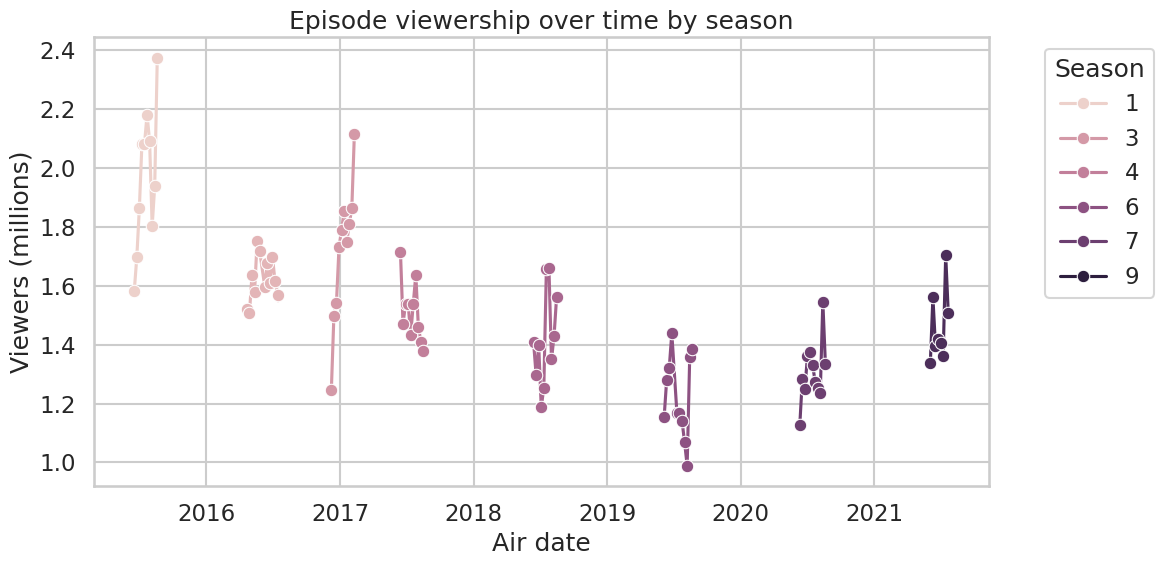

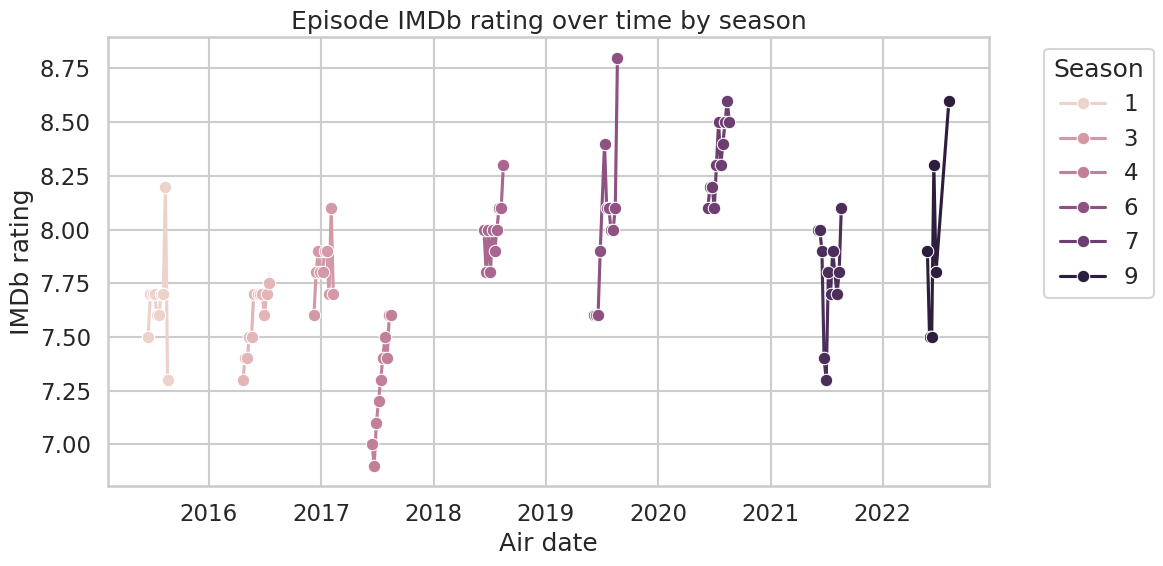

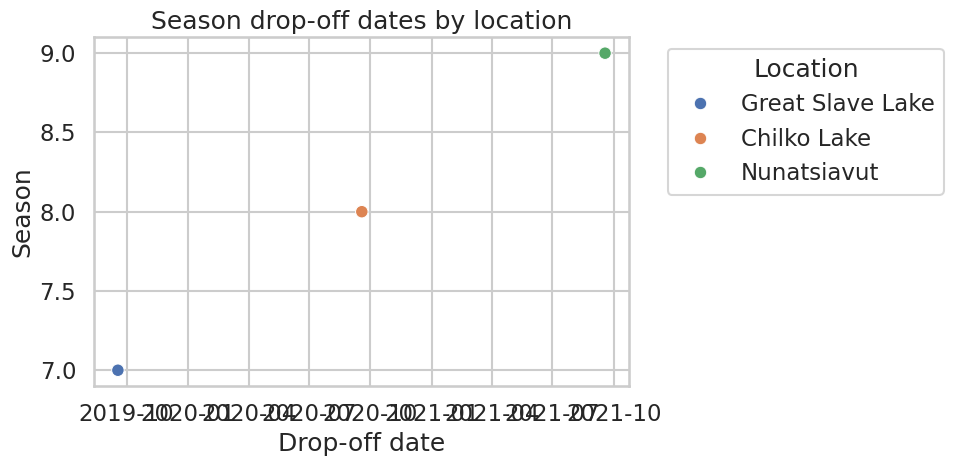

In [ ]:
# Time-based exploration of episodes and seasons

# Episodes: trends over air_date
if "air_date" in episodes.columns:
    episodes_time = episodes.dropna(subset=["air_date"]).sort_values("air_date")

    if "viewers" in episodes_time.columns:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=episodes_time, x="air_date", y="viewers", hue="season", marker="o")
        plt.title("Episode viewership over time by season")
        plt.xlabel("Air date")
        plt.ylabel("Viewers (millions)")
        plt.legend(title="Season", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    if "imdb_rating" in episodes_time.columns:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=episodes_time, x="air_date", y="imdb_rating", hue="season", marker="o")
        plt.title("Episode IMDb rating over time by season")
        plt.xlabel("Air date")
        plt.ylabel("IMDb rating")
        plt.legend(title="Season", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

# Seasons: drop-off dates if available
if "date_drop_off" in seasons.columns:
    seasons_time = seasons.dropna(subset=["date_drop_off"]).sort_values("date_drop_off")
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=seasons_time, x="date_drop_off", y="season", hue="location")
    plt.title("Season drop-off dates by location")
    plt.xlabel("Drop-off date")
    plt.ylabel("Season")
    plt.legend(title="Location", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### B.4 Question-Driven EDA: Key Survival Insights

This section answers specific questions about the datasets: age distribution, survival duration, gender distribution, IMDb ratings, viewership, and most-selected survival items.


#### B.4.1 Participants' Ages: Distribution and Outliers

We examine the age distribution of survivalists and identify potential outliers.


Age summary (years):
count    94.00000
mean     37.93617
std       8.84491
min      19.00000
25%      31.00000
50%      38.50000
75%      44.00000
max      61.00000
Name: age, dtype: float64

IQR-based age outlier thresholds: < 11.5 or > 63.5 years
Number of outlier contestants by age: 0


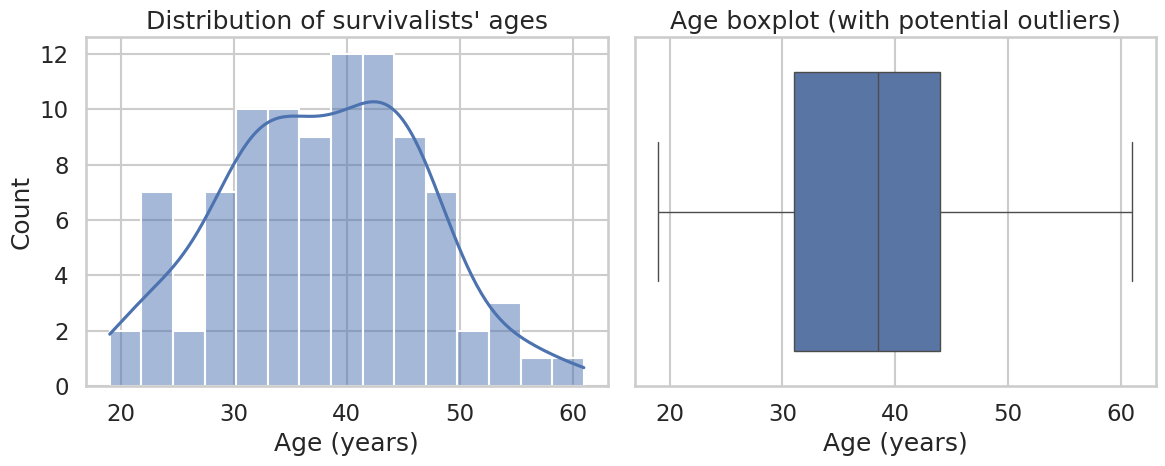

In [ ]:
# Age distribution and outliers for survivalists

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Work directly with the original survivalists_data loaded above
ages = survivalists_data["age"].dropna()

print("Age summary (years):")
print(ages.describe())

# Identify age outliers using the IQR rule
q1, q3 = ages.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"\nIQR-based age outlier thresholds: < {lower_bound:.1f} or > {upper_bound:.1f} years")

outliers_age = survivalists_data[(survivalists_data["age"] < lower_bound) | (survivalists_data["age"] > upper_bound)]

print(f"Number of outlier contestants by age: {len(outliers_age)}")
if not outliers_age.empty:
    display(outliers_age[["season", "name", "age", "gender"]].sort_values("age"))

# Plot age histogram and boxplot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(ages, bins=15, kde=True)
plt.title("Distribution of survivalists' ages")
plt.xlabel("Age (years)")

plt.subplot(1, 2, 2)
sns.boxplot(x=ages, orient="h")
plt.title("Age boxplot (with potential outliers)")
plt.xlabel("Age (years)")

plt.tight_layout()
plt.show()

#### B.4.2 Survival Duration: Distribution and Skewness

We examine how long contestants stay in the game (`days_lasted`).


Survival duration summary (days):
count     94.000000
mean      39.042553
std       27.849409
min        0.000000
25%       10.500000
50%       39.500000
75%       63.750000
max      100.000000
Name: days_lasted, dtype: float64

Skewness of days_lasted: 0.176


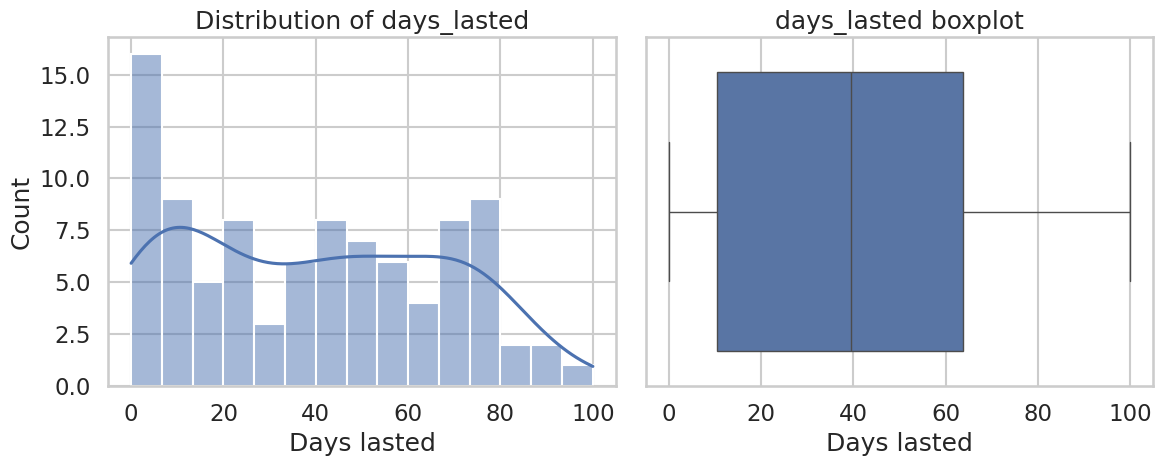

In [ ]:
# Survival duration distribution and skewness

survival_days = survivalists_data["days_lasted"].dropna()

print("Survival duration summary (days):")
print(survival_days.describe())
print(f"\nSkewness of days_lasted: {survival_days.skew():.3f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(survival_days, bins=15, kde=True)
plt.title("Distribution of days_lasted")
plt.xlabel("Days lasted")

plt.subplot(1, 2, 2)
sns.boxplot(x=survival_days, orient="h")
plt.title("days_lasted boxplot")
plt.xlabel("Days lasted")

plt.tight_layout()
plt.show()

#### B.4.3 Gender Distribution Across Seasons


Overall gender counts:
gender
Male      74
Female    20
Name: count, dtype: int64


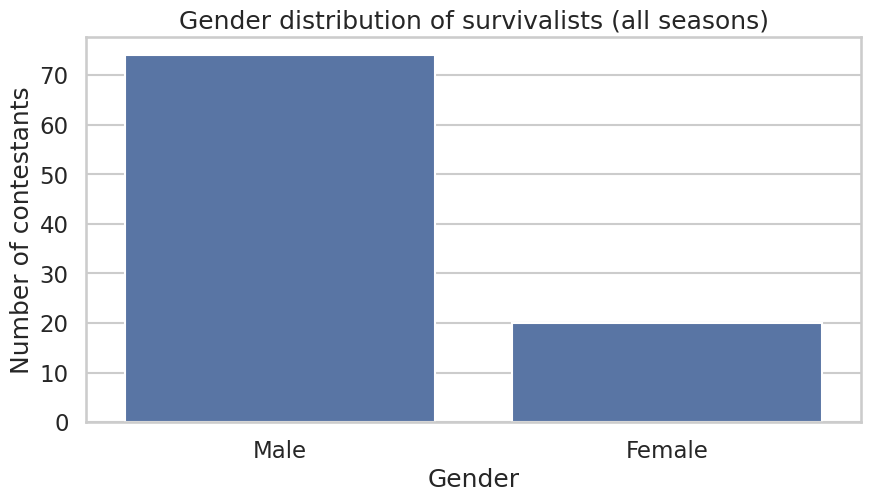


Gender counts by season:


gender,Female,Male
season,,
1,0,10
2,3,7
3,3,7
4,1,13
5,3,7
6,3,7
7,2,8
8,3,7
9,2,8


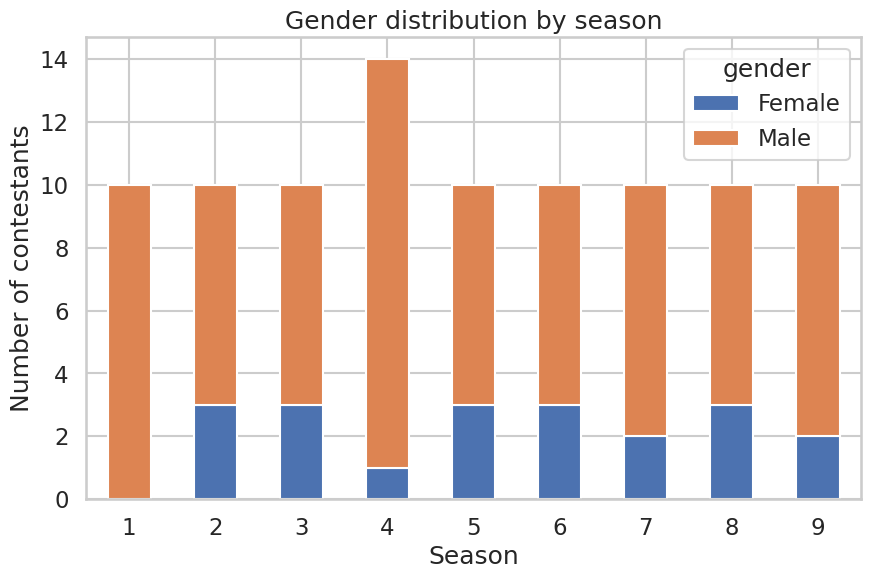

In [ ]:
# Gender distribution overall and by season

# Overall gender counts
print("Overall gender counts:")
gender_counts = survivalists_data["gender"].value_counts(dropna=False)
print(gender_counts)

plt.figure(figsize=(10, 5))
sns.countplot(x="gender", data=survivalists_data)
plt.title("Gender distribution of survivalists (all seasons)")
plt.xlabel("Gender")
plt.ylabel("Number of contestants")
plt.show()

# Gender by season (stacked counts style via pivot table)
if "season" in survivalists_data.columns:
    gender_by_season = survivalists_data.pivot_table(
        index="season", columns="gender", values="name", aggfunc="count", fill_value=0
    )
    print("\nGender counts by season:")
    display(gender_by_season)

    gender_by_season.plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.title("Gender distribution by season")
    plt.xlabel("Season")
    plt.ylabel("Number of contestants")
    plt.xticks(rotation=0)
    plt.show()

#### B.4.4 IMDb Ratings Across Episodes


IMDb rating summary:
count    93.000000
mean      7.821505
std       0.365302
min       6.900000
25%       7.600000
50%       7.800000
75%       8.100000
max       8.800000
Name: imdb_rating, dtype: float64


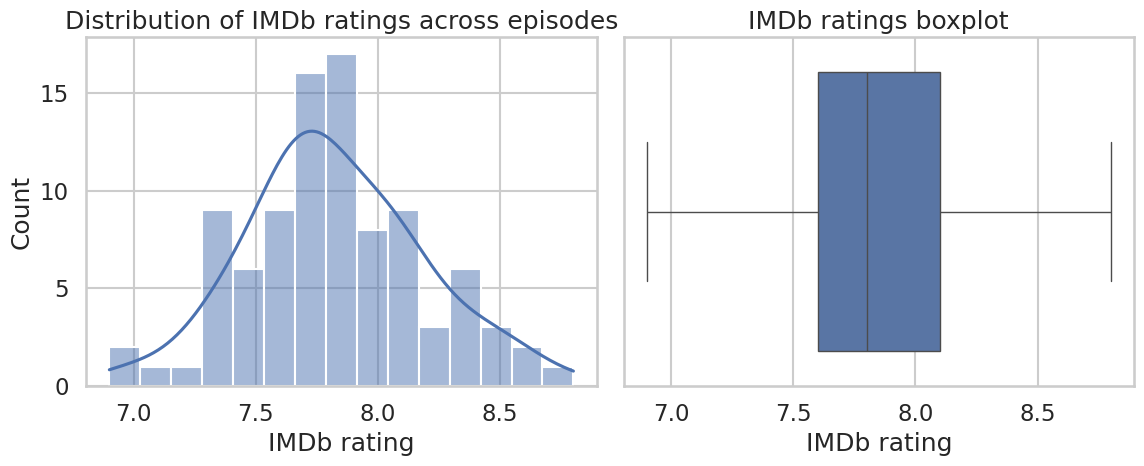

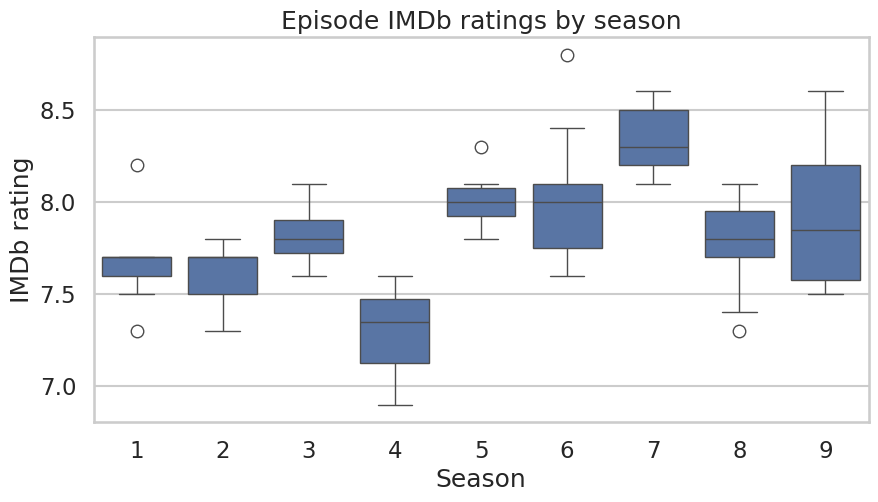

In [ ]:
# IMDb rating distribution across episodes

ratings = episodes_data["imdb_rating"].dropna()

print("IMDb rating summary:")
print(ratings.describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(ratings, bins=15, kde=True)
plt.title("Distribution of IMDb ratings across episodes")
plt.xlabel("IMDb rating")

plt.subplot(1, 2, 2)
sns.boxplot(x=ratings, orient="h")
plt.title("IMDb ratings boxplot")
plt.xlabel("IMDb rating")

plt.tight_layout()
plt.show()

# Rating by season (if available)
if "season" in episodes_data.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="season", y="imdb_rating", data=episodes_data)
    plt.title("Episode IMDb ratings by season")
    plt.xlabel("Season")
    plt.ylabel("IMDb rating")
    plt.show()

#### B.4.5 Episode Viewership Across Seasons


Viewership summary (millions):
count    83.000000
mean      1.527880
std       0.270149
min       0.989000
25%       1.344000
50%       1.507000
75%       1.687500
max       2.375000
Name: viewers, dtype: float64


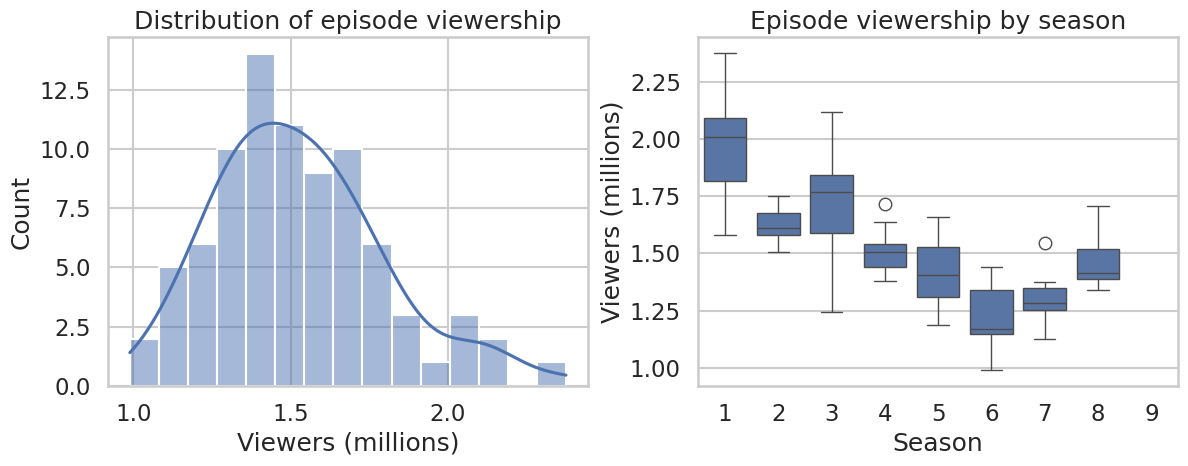


Average viewership by season:


,season,viewers
0,1,1.969700
1,2,1.619077
2,3,1.720400
3,4,1.512200
4,5,1.420400
5,6,1.224545
6,7,1.306818
7,8,1.461750
8,9,NaN


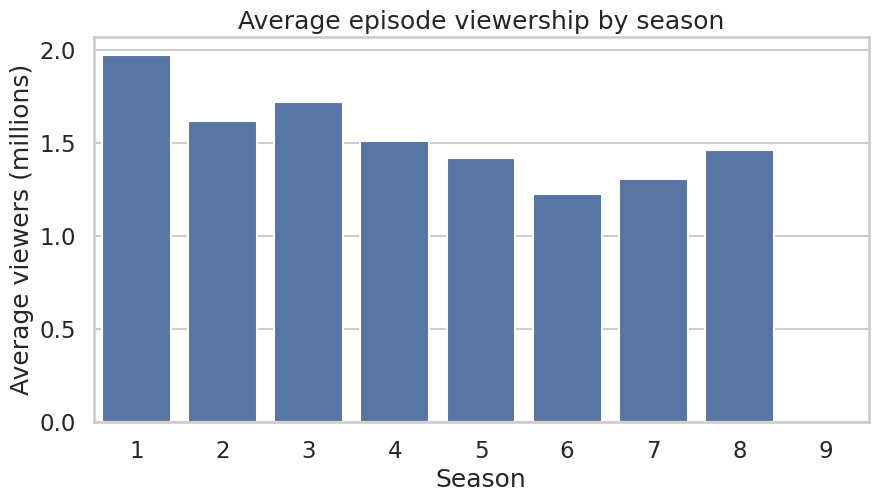

In [ ]:
# Episode viewership across seasons

viewers = episodes_data["viewers"].dropna()

print("Viewership summary (millions):")
print(viewers.describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(viewers, bins=15, kde=True)
plt.title("Distribution of episode viewership")
plt.xlabel("Viewers (millions)")

plt.subplot(1, 2, 2)
if "season" in episodes_data.columns:
    sns.boxplot(x="season", y="viewers", data=episodes_data)
    plt.title("Episode viewership by season")
    plt.xlabel("Season")
    plt.ylabel("Viewers (millions)")
else:
    sns.boxplot(x=viewers, orient="h")
    plt.title("Viewership boxplot")
    plt.xlabel("Viewers (millions)")

plt.tight_layout()
plt.show()

# Average viewership per season (if season column exists)
if "season" in episodes_data.columns:
    avg_viewers_by_season = episodes_data.groupby("season")["viewers"].mean().reset_index()
    print("\nAverage viewership by season:")
    display(avg_viewers_by_season)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="season", y="viewers", data=avg_viewers_by_season)
    plt.title("Average episode viewership by season")
    plt.xlabel("Season")
    plt.ylabel("Average viewers (millions)")
    plt.show()

#### B.4.6 Most Frequently Selected Survival Items


Top survival items by frequency:


,count
item,
Pot,92
Fishing gear,90
Sleeping bag,85
Axe,80
Saw,80
Ferro rod,77
Rations,68
Bow and arrows,60
Paracord,56


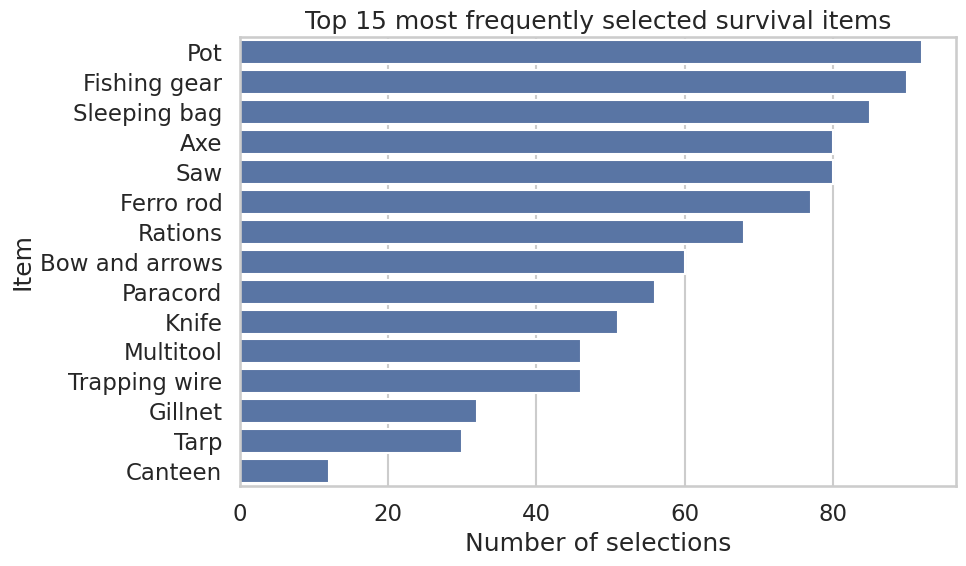

In [ ]:
# Most frequently selected survival items

# Count how often each item is chosen
item_counts = loadouts_data["item"].value_counts()

print("Top survival items by frequency:")
display(item_counts.to_frame(name="count").head(15))

# Bar chart of the top items
top_n = 15
top_items = item_counts.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_items.values, y=top_items.index, orient="h")
plt.title(f"Top {top_n} most frequently selected survival items")
plt.xlabel("Number of selections")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

**EDA summary:** Age, survival duration, gender, IMDb ratings, viewership, and item frequencies reveal the structure of the data. Skewed survival duration, dominant item choices, and rating/viewership variation across seasons set the stage for clustering and association analysis. The next sections build on this foundation.


---
## C. Correlated vs. Uncorrelated Features

Understanding the relationships between episode-level variables before modeling is crucial. Correlation heatmap results show that variables like *season*, *episode*, and *episode_number_overall* are strongly correlated because they represent the same structural information. Therefore, using them together in clustering analysis can distort results by affecting distance calculations, and such repetitive variables should be excluded from the analysis.

In contrast, variables like *imdb_rating*, *n_ratings*, and *viewers* show weaker correlations and represent different dimensions of viewer engagement. Since the IMDb rating reflects perceived quality, the number of votes reflects user participation, and the number of viewers reflects reach, these variables can be used as separate and meaningful dimensions in clustering analysis. Therefore, focusing on these variables, which provide more independent information, leads to more accurate results.

---

## D. IMDb Ratings Deep Dive and Episode-Level Clustering

**Research Question:** How do episodes and seasons cluster by IMDb rating and engagement metrics?

Building on EDA, this section applies unsupervised clustering at both the episode and season level.


IMDb rating summary (non-missing):


,imdb_rating
count,93.000000
mean,7.821505
std,0.365302
min,6.900000
25%,7.600000
50%,7.800000
75%,8.100000
max,8.800000


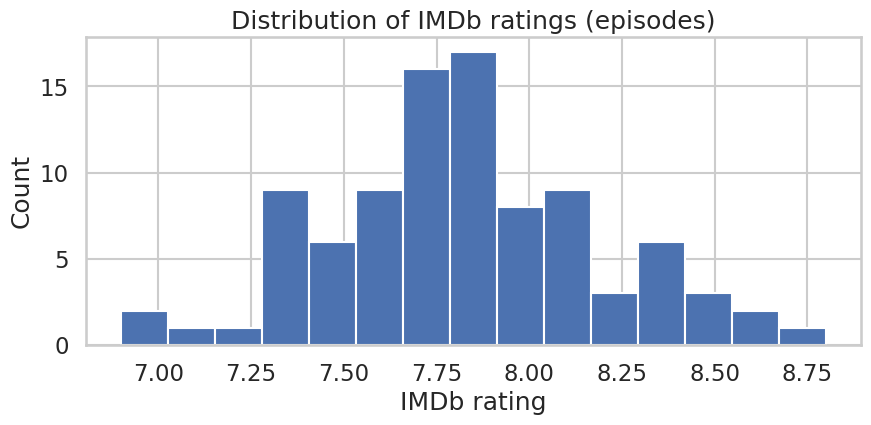

In [ ]:
# Distribution of IMDb Ratings for Episodes

print("IMDb rating summary (non-missing):")
display(episodes_r["imdb_rating"].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(episodes_r["imdb_rating"], bins=15)
plt.title("Distribution of IMDb ratings (episodes)")
plt.xlabel("IMDb rating")
plt.ylabel("Count")
plt.show()

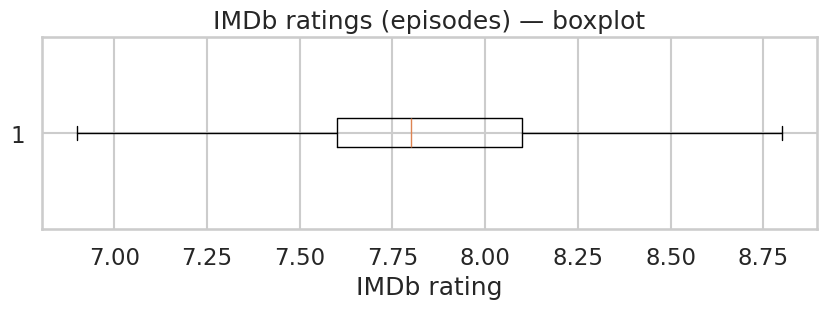

In [ ]:
# IMDb Ratings for Episodes

plt.figure(figsize=(10, 2.5))
plt.boxplot(episodes_r["imdb_rating"], vert=False)
plt.title("IMDb ratings (episodes) — boxplot")
plt.xlabel("IMDb rating")
plt.show()

In [ ]:
# Summary of Alone Seasons

season_summary = (
    episodes_r.groupby("season", dropna=False)
    .agg(
        n_episodes=("imdb_rating", "size"),
        mean_rating=("imdb_rating", "mean"),
        std_rating=("imdb_rating", "std"),
        min_rating=("imdb_rating", "min"),
        max_rating=("imdb_rating", "max"),
    )
    .reset_index()
    .sort_values("season")
)

display(season_summary)

,season,n_episodes,mean_rating,std_rating,min_rating,max_rating
0,1,11,7.672727,0.214900,7.3,8.2
1,2,13,7.592308,0.155250,7.3,7.8
2,3,10,7.820000,0.139841,7.6,8.1
3,4,10,7.300000,0.244949,6.9,7.6
4,5,10,8.000000,0.149071,7.8,8.3
5,6,11,8.018182,0.362817,7.6,8.8
6,7,11,8.336364,0.174773,8.1,8.6
7,8,11,7.781818,0.248267,7.3,8.1
8,9,6,7.933333,0.441210,7.5,8.6


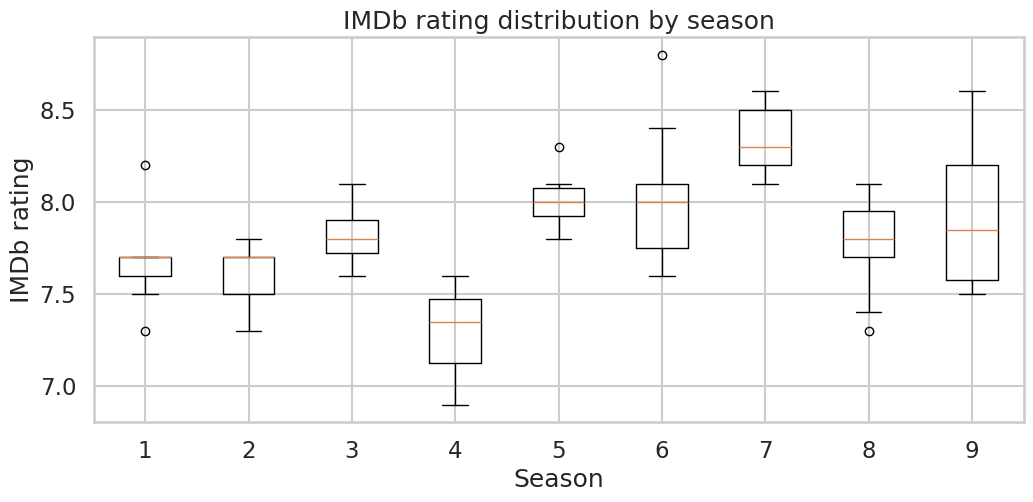

In [ ]:
# IMDb rating distributionby season

seasons_sorted = season_summary["season"].tolist()
data_by_season = [episodes_r.loc[episodes_r["season"] == s, "imdb_rating"].values for s in seasons_sorted]

plt.figure(figsize=(12, 5))
plt.boxplot(data_by_season, tick_labels=seasons_sorted, showfliers=True)
plt.title("IMDb rating distribution by season")
plt.xlabel("Season")
plt.ylabel("IMDb rating")
plt.show()

In [ ]:
# Top and Bottom 5 Episodes

cols_show = ["season", "episode", "episode_number_overall", "title", "air_date", "imdb_rating", "n_ratings"]

top_eps = episodes_r.sort_values("imdb_rating", ascending=False).head(5)[cols_show]
bottom_eps = episodes_r.sort_values("imdb_rating", ascending=True).head(5)[cols_show]

print("Top 5 rated episodes:")
display(top_eps)

print("Bottom 5 rated episodes:")
display(bottom_eps)

Top 5 rated episodes:


,season,episode,episode_number_overall,title,air_date,imdb_rating,n_ratings
64,6,11,66,Fire and Ice,2019-08-22,8.8,66.0
74,7,10,76,Pins and Needles,2020-08-13,8.6,68.0
97,9,11,100,"Fight, Flight or Freeze",2022-08-04,8.6,5.0
70,7,6,72,The Musk Ox,2020-07-16,8.5,72.0
73,7,9,75,The Wolves,2020-08-06,8.5,70.0


Bottom 5 rated episodes:


,season,episode,episode_number_overall,title,air_date,imdb_rating,n_ratings
35,4,2,36,Hell on Earth,2017-06-22,6.9,53.0
34,4,1,35,Divide and Conquer,2017-06-15,7.0,55.0
36,4,3,37,Margin of Error,2017-06-29,7.1,48.0
37,4,4,38,The Last Mile,2017-07-06,7.2,46.0
10,1,11,11,Triumph,2015-08-20,7.3,75.0


In [ ]:
# .describe of imdb_rating
episodes_r["imdb_rating"].describe()

,imdb_rating
count,93.000000
mean,7.821505
std,0.365302
min,6.900000
25%,7.600000
50%,7.800000
75%,8.100000
max,8.800000


In [ ]:
# Checking for episodes with ratings below 20:

episodes_r["n_ratings"].describe()

low_vote = episodes_r[episodes_r["n_ratings"] < 20][["season","episode","title","imdb_rating","n_ratings"]]
print("Episodes with n_ratings < 20:", len(low_vote))
display(low_vote.sort_values(["n_ratings","imdb_rating"]))

Episodes with n_ratings < 20: 1


,season,episode,title,imdb_rating,n_ratings
97,9,11,"Fight, Flight or Freeze",8.6,5.0


### D.1 Episode-Level Clustering: Method Integration

We cluster episodes using `imdb_rating` and `n_ratings` first, then extend to a richer feature set including `viewers`. The two approaches are compared to assess whether adding viewership changes cluster structure.


In [ ]:
# Build episode-level feature dataset (df)
df = episodes_r[["imdb_rating", "n_ratings"]].copy()
df

,imdb_rating,n_ratings
0,7.5,135.0
1,7.7,110.0
2,7.7,104.0
3,7.7,104.0
4,7.6,99.0
...,...,...
88,7.5,31.0
89,7.5,32.0
90,8.3,31.0
91,7.8,26.0


In [ ]:
# Standardize episode-level features (df_normalized)
from sklearn.preprocessing import StandardScaler
import pandas as pd

sc = StandardScaler()

df_normalized = pd.DataFrame(
    sc.fit_transform(df),
    columns=df.columns
)

df_normalized

,imdb_rating,n_ratings
0,-0.884879,3.608594
1,-0.334419,2.356918
2,-0.334419,2.056516
3,-0.334419,2.056516
4,-0.609649,1.806181
...,...,...
88,-0.884879,-1.598376
89,-0.884879,-1.548309
90,1.316960,-1.598376
91,-0.059189,-1.848711


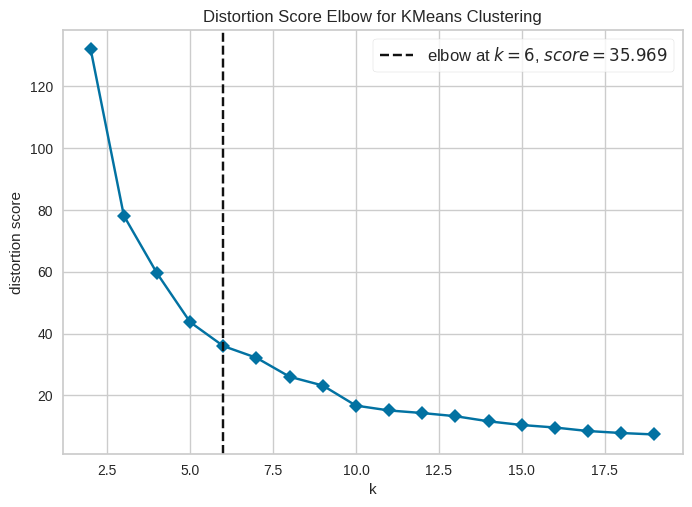

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# KMeans elbow plot (Yellowbrick)
!pip -q install yellowbrick

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric="distortion", timings=False, random_state=42
)

visualizer.fit(df_normalized)
visualizer.show()

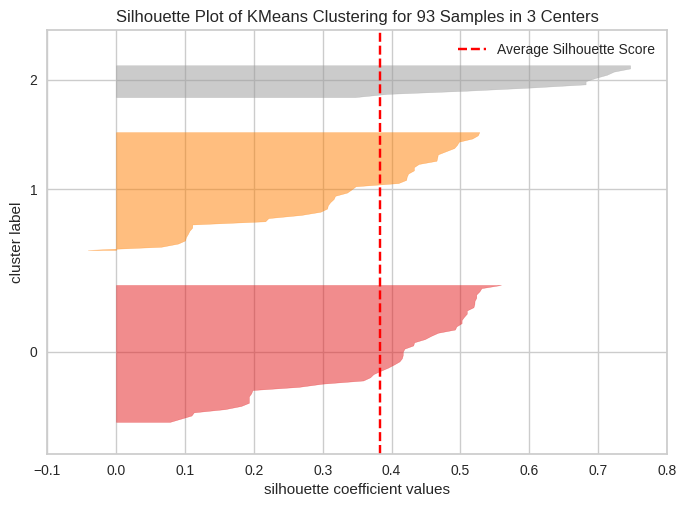

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# KMeans silhouette plot (Yellowbrick)
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

n_clusters_kmeans = 3

kmeans_model = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(df_normalized)
visualizer.show()

In [ ]:
# Fit final KMeans + store labels in df_normalized
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)

df_normalized["cluster_labels_km"] = kmeans.fit_predict(df_normalized).astype(str)

print(df_normalized["cluster_labels_km"].value_counts())

cluster_labels_km
0    44
1    38
2    11
Name: count, dtype: int64


In [ ]:
# Merge KMeans labels back to episode metadata (df_ep_labeled)
df_ep_labeled = episodes_r.copy()
df_ep_labeled["cluster_labels_km"] = df_normalized["cluster_labels_km"].values

cols_show = ["season", "episode", "title", "imdb_rating", "n_ratings", "cluster_labels_km"]
df_ep_labeled[cols_show].head()

,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
0,1,1,And So It Begins,7.5,135.0,2
1,1,2,Of Wolf and Man,7.7,110.0,2
2,1,3,The Talons of Fear,7.7,104.0,2
3,1,4,Stalked,7.7,104.0,2
4,1,5,Winds of Hell,7.6,99.0,2


In [ ]:
# Cluster summary table (KMeans interpretation)
cluster_summary_ep = (
    df_ep_labeled.groupby("cluster_labels_km")
    .agg(
        n=("imdb_rating", "size"),
        mean_rating=("imdb_rating", "mean"),
        std_rating=("imdb_rating", "std"),
        mean_votes=("n_ratings", "mean"),
        min_rating=("imdb_rating", "min"),
        max_rating=("imdb_rating", "max"),
    )
    .sort_index()
)

cluster_summary_ep

,n,mean_rating,std_rating,mean_votes,min_rating,max_rating
cluster_labels_km,,,,,,
0,44,7.552273,0.227717,57.068182,6.9,7.8
1,38,8.157895,0.237818,58.078947,7.9,8.8
2,11,7.736364,0.196330,103.090909,7.5,8.2


In [ ]:
# Representative episodes per cluster (top/bottom by rating)
cols = ["season", "episode", "title", "imdb_rating", "n_ratings", "cluster_labels_km"]

for c in sorted(df_ep_labeled["cluster_labels_km"].unique()):
    print(f"\nCluster {c} — top 5 by rating")
    display(
        df_ep_labeled[df_ep_labeled["cluster_labels_km"] == c]
        .sort_values("imdb_rating", ascending=False)[cols]
        .head(5)
    )

    print(f"Cluster {c} — bottom 5 by rating")
    display(
        df_ep_labeled[df_ep_labeled["cluster_labels_km"] == c]
        .sort_values("imdb_rating", ascending=True)[cols]
        .head(5)
    )


Cluster 0 — top 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
27,3,4,Outfoxed,7.8,63.0,0
28,3,5,The Lone Wolf,7.8,61.0,0
25,3,2,First Blood,7.8,67.0,0
91,9,5,The Land Giveth…,7.8,26.0,0
47,5,4,Mongolia's Wrath,7.8,50.0,0


Cluster 0 — bottom 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
35,4,2,Hell on Earth,6.9,53.0,0
34,4,1,Divide and Conquer,7.0,55.0,0
36,4,3,Margin of Error,7.1,48.0,0
37,4,4,The Last Mile,7.2,46.0,0
10,1,11,Triumph,7.3,75.0,0



Cluster 1 — top 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
64,6,11,Fire and Ice,8.8,66.0,1
74,7,10,Pins and Needles,8.6,68.0,1
97,9,11,"Fight, Flight or Freeze",8.6,5.0,1
73,7,9,The Wolves,8.5,70.0,1
75,7,11,Over the Edge,8.5,85.0,1


Cluster 1 — bottom 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
26,3,3,Eternal Darkness,7.9,63.0,1
29,3,6,Along Came a Spider,7.9,62.0,1
30,3,7,Hungry Beasts,7.9,58.0,1
49,5,6,Of Mice And Men,7.9,48.0,1
57,6,4,The Moose,7.9,61.0,1



Cluster 2 — top 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
9,1,10,Brokedown Palace,8.2,102.0,2
76,8,1,The Hunted,8.0,92.0,2
1,1,2,Of Wolf and Man,7.7,110.0,2
8,1,9,The Freeze,7.7,93.0,2
2,1,3,The Talons of Fear,7.7,104.0,2


Cluster 2 — bottom 5 by rating


,season,episode,title,imdb_rating,n_ratings,cluster_labels_km
0,1,1,And So It Begins,7.5,135.0,2
4,1,5,Winds of Hell,7.6,99.0,2
5,1,6,Rain of Terror,7.6,99.0,2
1,1,2,Of Wolf and Man,7.7,110.0,2
3,1,4,Stalked,7.7,104.0,2


In [ ]:
# Cluster distribution by season (counts)
import pandas as pd

season_cluster_ct = pd.crosstab(df_ep_labeled["season"], df_ep_labeled["cluster_labels_km"])
display(season_cluster_ct)

cluster_labels_km,0,1,2
season,,,
1,1,0,10
2,13,0,0
3,6,4,0
4,10,0,0
5,2,8,0
6,3,8,0
7,0,11,0
8,6,4,1
9,3,3,0


In [ ]:
# Cluster distribution by season (row-normalized percentages)
season_cluster_pct = pd.crosstab(
    df_ep_labeled["season"],
    df_ep_labeled["cluster_labels_km"],
    normalize="index"
).round(3)

display(season_cluster_pct)

cluster_labels_km,0,1,2
season,,,
1,0.091,0.000,0.909
2,1.000,0.000,0.000
3,0.600,0.400,0.000
4,1.000,0.000,0.000
5,0.200,0.800,0.000
6,0.273,0.727,0.000
7,0.000,1.000,0.000
8,0.545,0.364,0.091
9,0.500,0.500,0.000


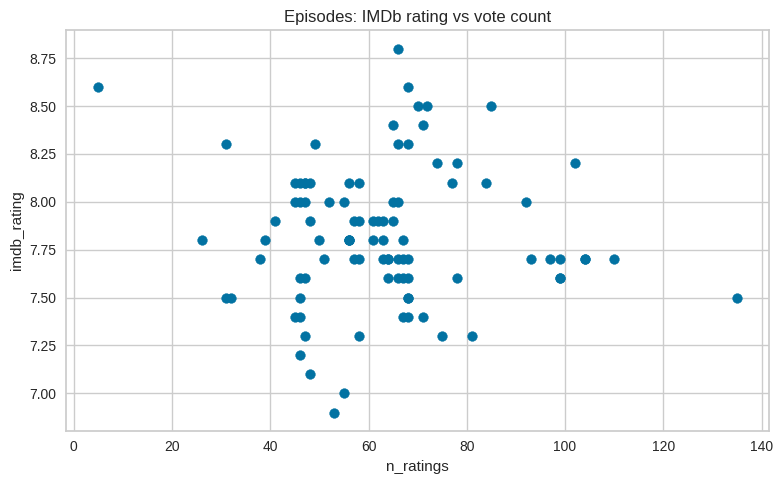

In [ ]:
# Diagnostic scatter: rating vs vote count
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df_ep_labeled["n_ratings"], df_ep_labeled["imdb_rating"])
plt.xlabel("n_ratings")
plt.ylabel("imdb_rating")
plt.title("Episodes: IMDb rating vs vote count")
plt.tight_layout()
plt.show()

---
## E. Episode Segmentation with Viewership (Primary Clustering Approach)

**Research Question:** Can we meaningfully segment episodes using viewers, IMDb ratings, and vote counts together?

This approach adds viewers as a third feature dimension and hierarchical clustering at k = 3. Interactive 3D scatter plots visualize cluster separation across three features.


In [ ]:
# Clustering setup
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Select numeric columns only (Example uses df with MedInc, HouseAge, etc.)
# Mapping: season, episode, viewers, imdb_rating, n_ratings = closest numeric features in episodes
num_cols = [c for c in ["season", "episode", "viewers", "imdb_rating", "n_ratings"] if c in episodes.columns]
episodes_seg = episodes[num_cols].copy()

# 2) Handle missing values
for c in num_cols:
    episodes_seg[c] = episodes_seg[c].fillna(episodes_seg[c].median())

display(episodes_seg)


,season,episode,viewers,imdb_rating,n_ratings
0,1,1,1.582,7.5,135.0
1,1,2,1.697,7.7,110.0
2,1,3,1.864,7.7,104.0
3,1,4,2.082,7.7,104.0
4,1,5,2.082,7.6,99.0
...,...,...,...,...,...
93,9,7,1.507,7.8,63.0
94,9,8,1.507,7.8,63.0
95,9,9,1.507,7.8,63.0
96,9,10,1.507,7.8,63.0


### E.1 Hierarchical Clustering with Ward Linkage


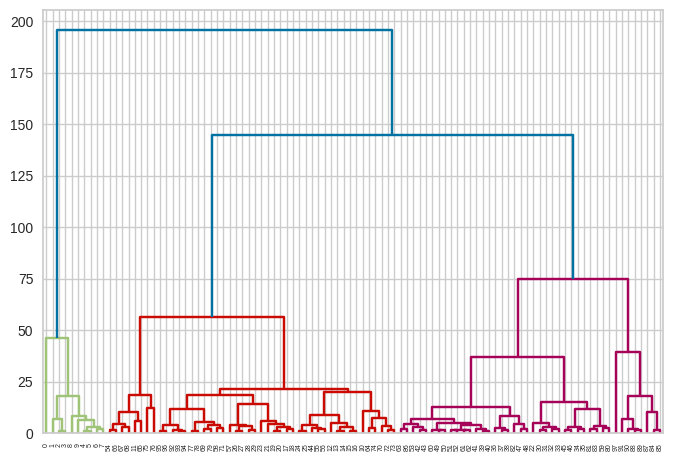

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
# Dendrogram
Z = linkage(episodes_seg, "ward")
_ = dendrogram(Z)
plt.show()

# Choose K (initial setup n_clusters = 3)
n_clusters = 3
episodes_seg["cluster_labels"] = fcluster(Z, n_clusters, criterion="maxclust").astype(str)
episodes_seg["cluster_labels"].value_counts()

# Feature Normalization
sc = StandardScaler()
df_normalized = episodes_seg.drop("cluster_labels", axis=1)
df_normalized = pd.DataFrame(sc.fit_transform(df_normalized), columns=df_normalized.columns)


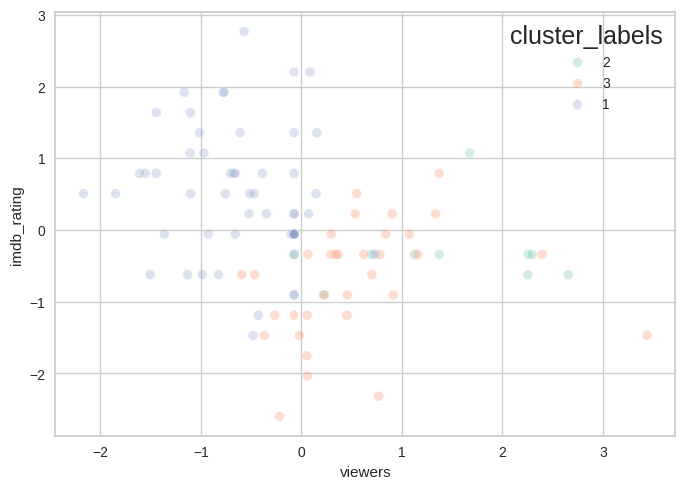

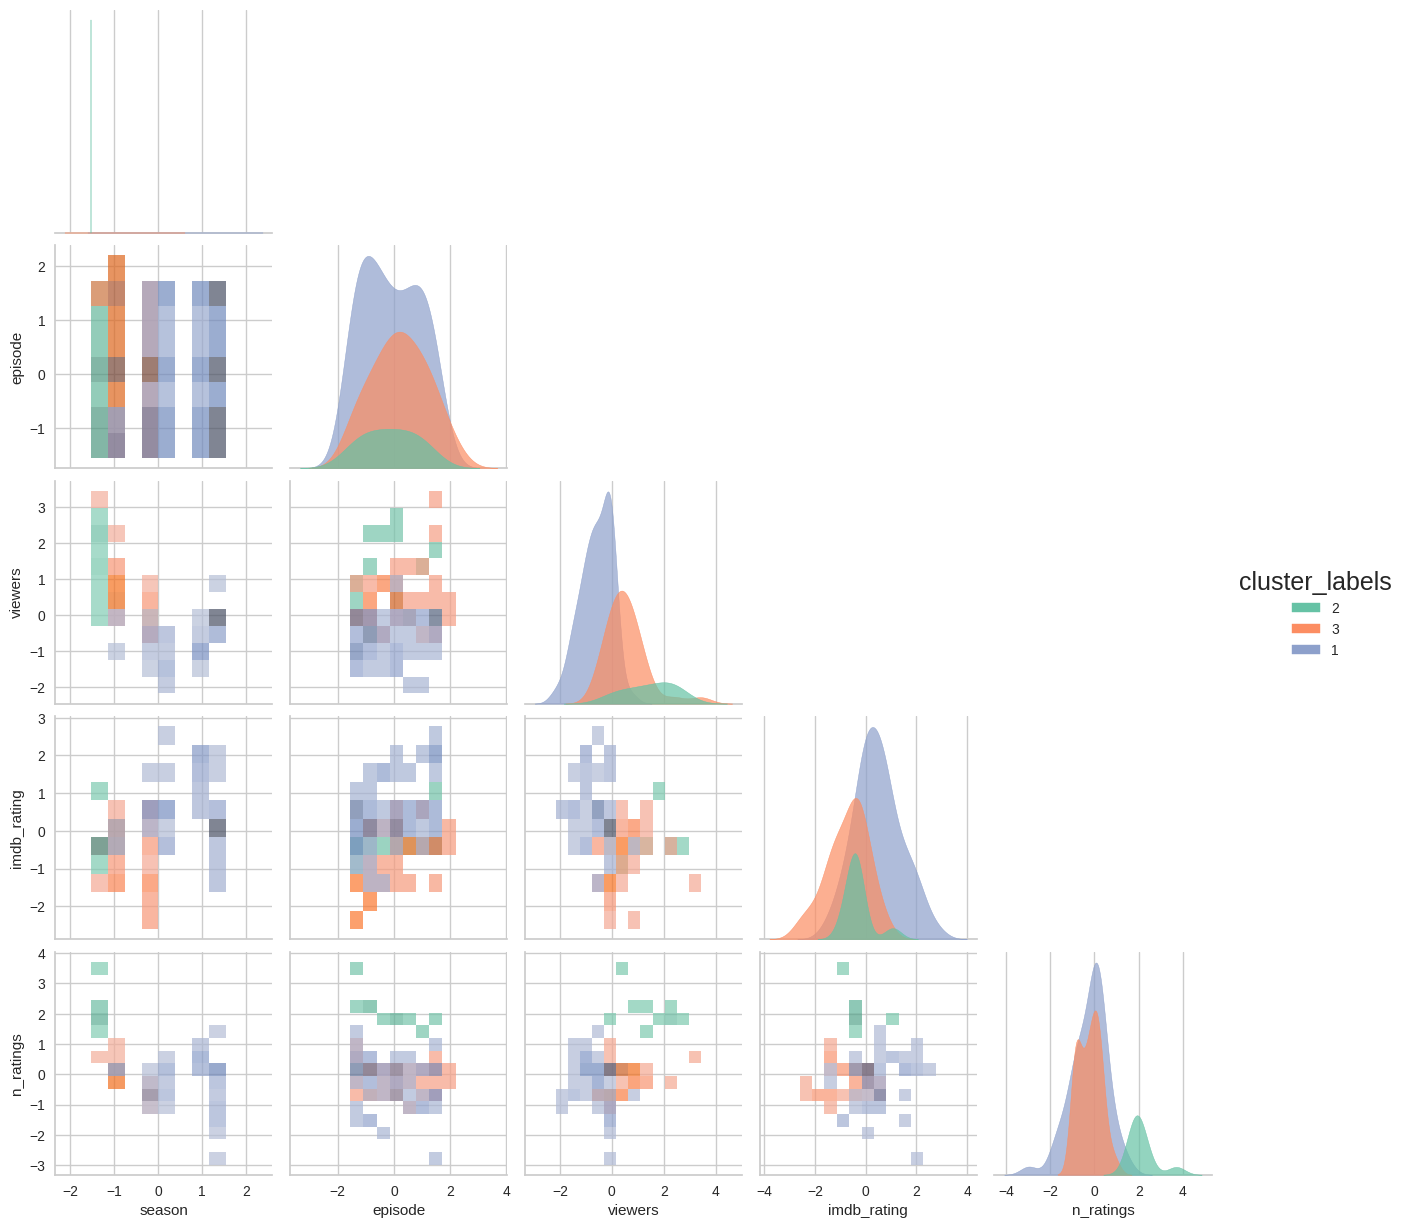

In [ ]:
# Hierarchical on normalized data
Z = linkage(df_normalized, "ward")
df_normalized["cluster_labels"] = fcluster(Z, n_clusters, criterion="maxclust").astype(str)

sns.scatterplot(df_normalized, x="viewers", y="imdb_rating", hue="cluster_labels", palette="Set2", alpha=0.3)
plt.show()

sns.pairplot(df_normalized, hue="cluster_labels", kind="hist", diag_kind="kde", corner=True, palette="Set2",
             plot_kws={"alpha": 0.7}, diag_kws={"alpha": 0.7})
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_normalized, x='viewers', y='imdb_rating', z='n_ratings', color='cluster_labels',
                    opacity=0.5, color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=3))
fig.show()

### E.2 Interpretation (n_clusters = 3)

**What we did:** Applied hierarchical clustering with Ward linkage and cut the dendrogram at k = 3.

**What the output shows:** The dendrogram indicates three main branches merge at high distance, suggesting three distinct content segments. The 3D scatter plot separates episodes by viewers, IMDb rating, and n_ratings.

**Why it matters:** A three-cluster solution offers a parsimonious segmentation: popular episodes (high viewers, ratings, votes), mid-range episodes, and niche or lower-engagement episodes. This supports content strategy and programming decisions.


**Dendrogram summary:** Most episodes first group into small similar clusters. Three main branches appear, merging only at high distance. Cutting at k = 3 fits the main structure.

**Cluster profile (from outputs):** Cluster 2 tends to include episodes with higher viewers, IMDb ratings, and number of ratings (popular episodes). Cluster 3 tends toward lower values (niche episodes).


---
## F. Tap-Out Narrative Analysis

**Research Question:** What patterns exist in contestants' tap-out narratives? Are there distinct themes of exit?

This section applies NLP methods (NMF topic modeling, TF-IDF, sentence embeddings, and KMeans clustering) to the tap-out reason text. It complements the quantitative clustering by revealing thematic structure in qualitative exit narratives.


In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# These are the files
SURVIVALISTS_PATH = "https://drive.google.com/uc?export=download&id=1L600G_6QA1XVZGKl3Ky5AC9FWC4Uu3po"
LOADOUTS_PATH     = "https://drive.google.com/uc?export=download&id=1xym94LM-MIvEWI-IauIJViR4mXaqMiB0"
EPISODES_PATH     = "https://drive.google.com/uc?export=download&id=1Q2s1TZAl1epx_-hi8yXWQv12UJGt_LYe"
SEASONS_PATH      = "https://drive.google.com/uc?export=download&id=1M1cEpgPXD1PTLywN2JD7Dn8-QEWcUfWQ"

In [ ]:
# use shared survivalists_data loaded in Section 1
survivalists = survivalists_data.copy()
print("survivalists shape:", survivalists.shape)
print("columns:\n", survivalists.columns.tolist())

# this is the tap-out narrative column
cands = [c for c in survivalists.columns if 'reason' in c.lower() or 'tap' in c.lower() or 'quit' in c.lower() or 'why' in c.lower()]
print("Candidate tap-out columns:", cands)

survivalists shape: (94, 16)
columns:
 ['season', 'name', 'age', 'gender', 'city', 'state', 'country', 'result', 'days_lasted', 'medically_evacuated', 'reason_tapped_out', 'reason_category', 'team', 'day_linked_up', 'profession', 'url']
Candidate tap-out columns: ['reason_tapped_out', 'reason_category']


### F.1 Load and Basic Check


Rows total: 94
Missing tap text: 10 (10.6%)
Duplicate narratives (exact text duplicates): 23

--- Sample raw narratives ---
1. Lost fire starter
2. Missed his family
3. Constipation, possible impacted bowel
4. Systolic pressure too low
5. Felt too exhausted and drained to go on
6. Nothing left to give
7. Starvation
8. Had nothing left to accomplish
9. Missed family and felt guilty for having left them behind
10. Bear scare

Word count summary (raw):
count    84.000000
mean      3.750000
std       2.399172
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      11.000000
Name: wc_raw, dtype: float64


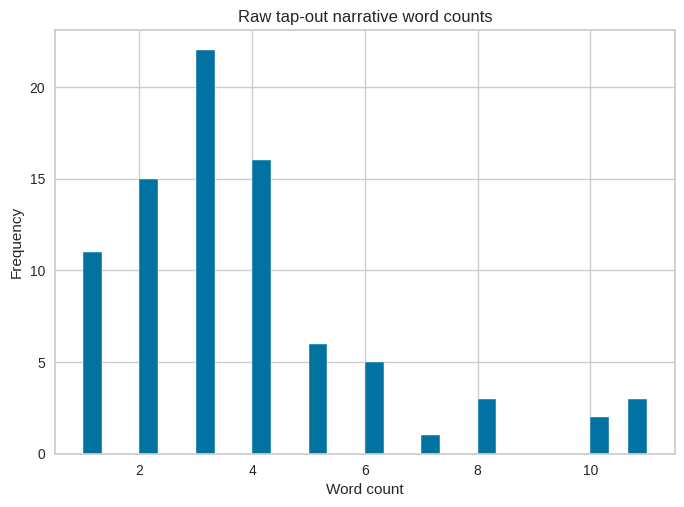

In [ ]:
TAP_COL = "reason_tapped_out"
assert TAP_COL is not None, "Set TAP_COL to your tap-out narrative column name first."

df = survivalists.copy()

# this will keep only the rows with some text
df["tap_raw"] = df[TAP_COL].astype(str)
df["tap_raw"] = df["tap_raw"].replace({"nan": np.nan, "None": np.nan, "": np.nan})
print("Rows total:", len(df))
print("Missing tap text:", df["tap_raw"].isna().sum(), f"({df['tap_raw'].isna().mean():.1%})")

# this code duplicates in narrative text
dup_text = df["tap_raw"].dropna().duplicated().sum()
print("Duplicate narratives (exact text duplicates):", dup_text)

# this code shows sample narratives
sample = df["tap_raw"].dropna().sample(min(10, df["tap_raw"].dropna().shape[0]), random_state=7).tolist()
print("\n--- Sample raw narratives ---")
for i, s in enumerate(sample, 1):
    print(f"{i}. {s[:200]}{'...' if len(s)>200 else ''}")

# this is the count
def word_count(s):
    if pd.isna(s): return np.nan
    return len(re.findall(r"\b\w+\b", str(s)))

df["wc_raw"] = df["tap_raw"].apply(word_count)

print("\nWord count summary (raw):")
print(df["wc_raw"].describe())

# Histogram graph
plt.figure()
df["wc_raw"].dropna().hist(bins=30)
plt.title("Raw tap-out narrative word counts")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()


### F.2 Text Cleaning Pipeline


Word count summary (cleaned):
count    84.000000
mean      3.071429
std       1.706019
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       8.000000
Name: wc_clean, dtype: float64

--- Before / After (5 examples) ---

RAW: Had nothing left to accomplish ...
CLN: nothing left accomplish ...

RAW: Lower back injury ...
CLN: lower back injury ...

RAW: Felt too exhausted and drained to go on ...
CLN: felt exhausted drained go ...

RAW: Missed his family ...
CLN: missed his family ...

RAW: Constipation, possible fecal impaction ...
CLN: constipation possible fecal impaction ...


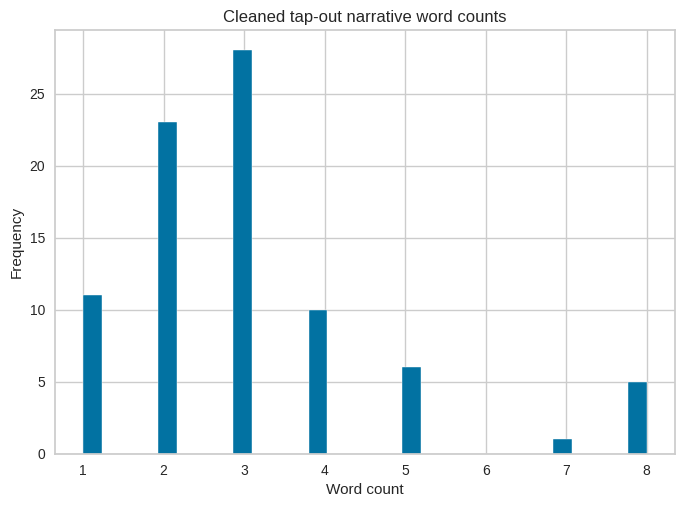

Short narratives (<5 words): 82 (87.2%)


In [ ]:
# these are the basic stopwords list
basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())

# we need to remove 'no'/'nor' so we keep negation meaning
basic_stop.discard("no")
basic_stop.discard("nor")
basic_stop.discard("not") if "not" in basic_stop else None

def clean_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    tokens = s.split()
    tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
    return " ".join(tokens)

df["tap_clean"] = df["tap_raw"].apply(clean_text)
df["wc_clean"] = df["tap_clean"].apply(word_count)

print("Word count summary (cleaned):")
print(df["wc_clean"].describe())

# these are before/after examples
ex = df[["tap_raw", "tap_clean"]].dropna().sample(min(5, df["tap_clean"].dropna().shape[0]), random_state=8)
print("\n--- Before / After (5 examples) ---")
for _, row in ex.iterrows():
    print("\nRAW:", str(row["tap_raw"])[:220], "...")
    print("CLN:", str(row["tap_clean"])[:220], "...")

# the hist of cleaned lengths
plt.figure()
df["wc_clean"].dropna().hist(bins=30)
plt.title("Cleaned tap-out narrative word counts")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

# these flag very short narratives
SHORT_THRESH = 5
df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH
print("Short narratives (<5 words):", df["is_short"].sum(), f"({df['is_short'].mean():.1%})")

### F.3 Exploratory Text EDA



Top 20 words:
[('low', 4), ('bmi', 4), ('lost', 4), ('much', 4), ('weight', 4), ('felt', 3), ('he', 2), ('jointly', 2), ('decided', 2), ('cost', 2), ('game', 2), ("wasn't", 2), ('worth', 2), ('it', 2), ('missed', 2), ('family', 2), ('guilty', 2), ('having', 2), ('left', 2), ('them', 2)]

Top 20 bigrams:
[('low bmi', 4), ('bmi lost', 4), ('lost much', 4), ('much weight', 4), ('jointly decided', 2), ('decided cost', 2), ('cost game', 2), ("game wasn't", 2), ("wasn't worth", 2), ('worth it', 2), ('missed family', 2), ('family felt', 2), ('felt guilty', 2), ('guilty having', 2), ('having left', 2), ('left them', 2), ('them behind', 2), ('realized he', 1), ('he actually', 1), ('actually around', 1)]


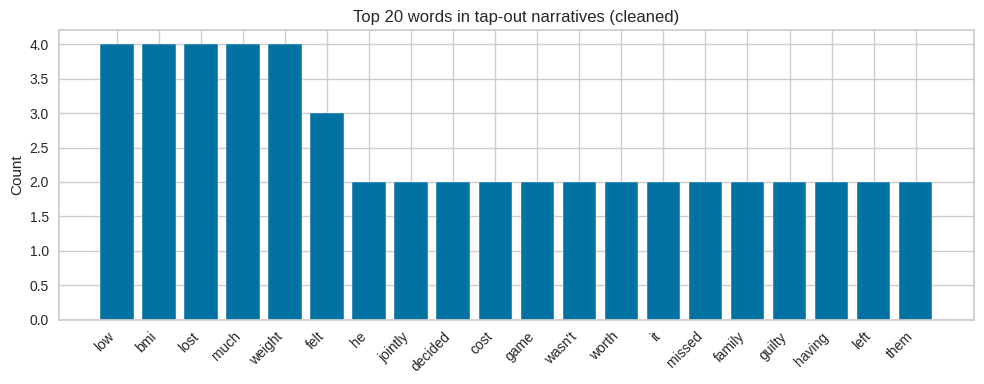

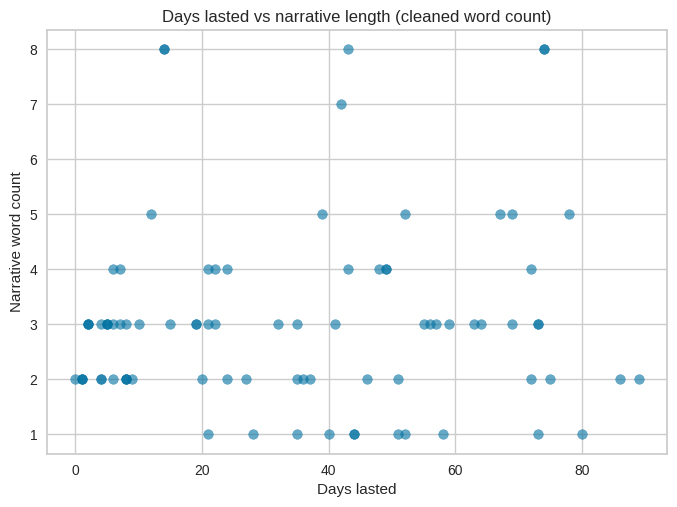

In [ ]:
texts = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()

# the top unigrams
all_words = " ".join(texts).split()
top_words = Counter(all_words).most_common(20)
print("\nTop 20 words:")
print(top_words)

# the top bigrams
bigrams = []
for t in texts:
    toks = t.split()
    bigrams += list(zip(toks[:-1], toks[1:]))
top_bigrams = Counter(bigrams).most_common(20)
print("\nTop 20 bigrams:")
print([(" ".join(bg), c) for bg, c in top_bigrams])

# plot the top 20 words
words, counts = zip(*top_words) if top_words else ([], [])
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 words in tap-out narratives (cleaned)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Define DAYS_COL here
DAYS_COL = "days_lasted"

# the word count vs days lasted
if DAYS_COL is not None and DAYS_COL in df.columns:
    tmp = df[[DAYS_COL, "wc_clean"]].copy()
    tmp = tmp.dropna()
    plt.figure()
    plt.scatter(tmp[DAYS_COL], tmp["wc_clean"], alpha=0.6)
    plt.title("Days lasted vs narrative length (cleaned word count)")
    plt.xlabel("Days lasted")
    plt.ylabel("Narrative word count")
    plt.show()
else:
    print("\nNo days-lasted column detected. If you have one, set DAYS_COL manually.")

### F.4 Method 1: Topic Modeling (NMF)


In [ ]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")
    # they could be re-define necessary functions/variables if the cleaning cell wasn't run
    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\b\w+\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^a-z0-9\s']", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH


docs = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()

# the TF-IDF works well for NMF
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X = tfidf.fit_transform(docs)
terms = np.array(tfidf.get_feature_names_out())

def print_nmf_topics(model, terms, top_n=12):
    for i, comp in enumerate(model.components_):
        top_idx = np.argsort(comp)[::-1][:top_n]
        print(f"\nTopic {i}: " + ", ".join(terms[top_idx]))

for k in [4, 6, 8, 10]:
    nmf = NMF(n_components=k, random_state=42, init="nndsvd", max_iter=400)
    W = nmf.fit_transform(X)
    print("\n" + "="*60)
    print(f"NMF with K={k}")
    print_nmf_topics(nmf, terms, top_n=12)


NMF with K=4

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, much, them, missed, low bmi

NMF with K=6

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, much, them, missed, low bmi

Topic 4: felt, worth it, weig

In [ ]:
FINAL_K = 6

nmf = NMF(n_components=FINAL_K, random_state=42, init="nndsvd", max_iter=400)
W = nmf.fit_transform(X)
topic_assign = W.argmax(axis=1)

# these show top words
print("\nFINAL NMF TOPICS")
print_nmf_topics(nmf, terms, top_n=15)

# the representative docs: highest topic weight per topic
idxs = np.arange(len(docs))
for t in range(FINAL_K):
    t_idxs = idxs[topic_assign == t]
    if len(t_idxs) == 0:
        continue
    # this ranks by strength
    strengths = W[t_idxs, t]
    top_docs = t_idxs[np.argsort(strengths)[::-1][:3]]
    print("\n" + "-"*60)
    print(f"Topic {t} representative narratives:")
    for j in top_docs:
        print(" •", docs[j][:250], "..." if len(docs[j])>250 else "")



FINAL NMF TOPICS

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn, wasn worth, worth, missed

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left, guilty having, having, felt

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn, game, weight, them behind

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, much, them, missed, low bmi, low, much weight, lost much

Topic 4: felt, worth it, weight, wasn worth, wasn, worth, them behind, them, much, much weight, missed, low bmi, low, missed family, lost

Topic 5: worth it, worth, weight, wasn worth, wasn, them behind, them, much weight, much, missed family, missed, low bmi, low, lost much, lost

------------------------------------------------------------
Topic 0 representative narratives:
 • low bmi lost muc

In [ ]:
cv = CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))
Xc = cv.fit_transform(docs)
terms_c = np.array(cv.get_feature_names_out())

for k in [6, 8]:
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(Xc)

    print("\n" + "=" * 60)
    print(f"LDA with K={k}")

    for i, comp in enumerate(lda.components_):
        top_idx = np.argsort(comp)[::-1][:12]
        print(f"Topic {i}: " + ", ".join(terms_c[top_idx]))



LDA with K=6
Topic 0: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn
Topic 1: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 2: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 3: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 4: felt, them behind, missed family, missed, them, left, family, behind, felt guilty, family felt, guilty having, having left
Topic 5: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, he, felt, worth it

LDA with K=8
Topic 0: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn
Topic 1: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 2: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low 

In [ ]:
# Deleting unnecessary rows
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.



Auto-selected FINAL_K_CLUST (max silhouette): 5


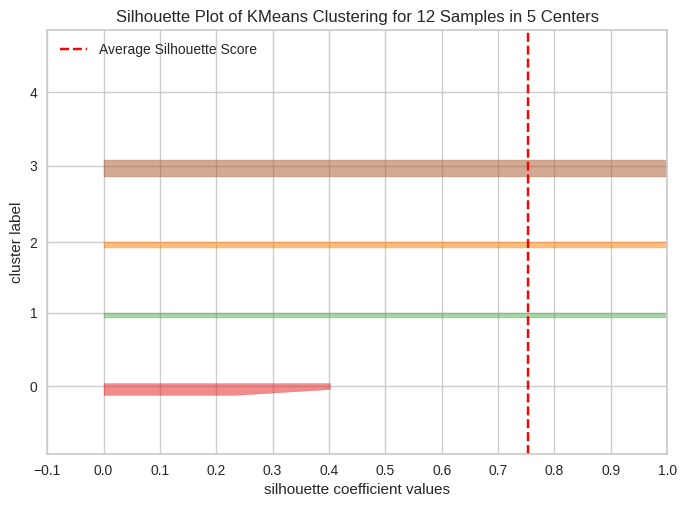

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 12 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Embeddings and scaling (moved from eve_-3qGQG9S to ensure availability)
tfidf2 = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X2 = tfidf2.fit_transform(docs)

svd_dims = 100
svd = TruncatedSVD(n_components=min(svd_dims, X2.shape[1]-1), random_state=42)
E = svd.fit_transform(X2)

sc = StandardScaler()
E_scaled = sc.fit_transform(E)

# for trying different K, track silhouette
Ks = [4, 5, 6, 7, 8, 10]
sil = {}
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(E)
    if len(set(labels)) > 1:
        sil[k] = silhouette_score(E, labels)
    else:
        sil[k] = np.nan

FINAL_K_CLUST = max(sil, key=lambda k: sil[k] if not np.isnan(sil[k]) else -1)
print("Auto-selected FINAL_K_CLUST (max silhouette):", FINAL_K_CLUST)

kmeans_model = KMeans(n_clusters=FINAL_K_CLUST, random_state=42, n_init=10)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(E_scaled)
visualizer.show()

### F.5 Method 2: Embeddings and Clustering


In [ ]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")

    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\\b\\w+\\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\\S+|www\\.\\S+", " ", s)
        s = re.sub(r"[^a-z0-9\\s']", " ", s)
        s = re.sub(r"\\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH

docs = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()


Cluster sizes:
0    2
1    4
2    2
3    2
4    2
Name: count, dtype: int64


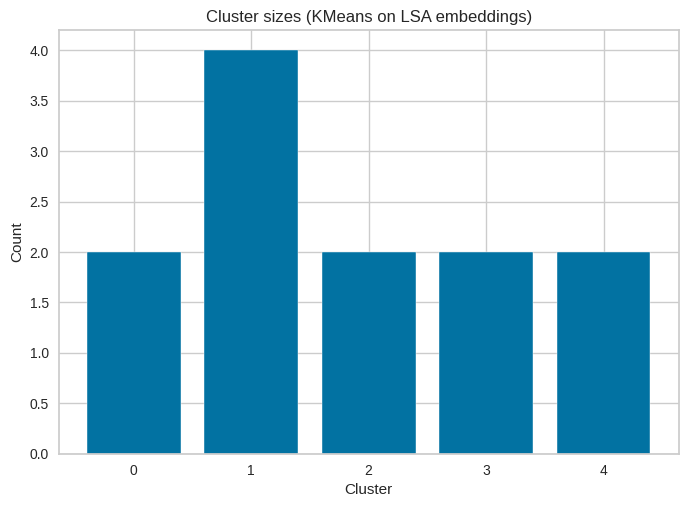


------------------------------------------------------------
Cluster 0 representative narratives:
 • jointly decided cost game wasn't worth it 
 • jointly decided cost game wasn't worth it 

------------------------------------------------------------
Cluster 1 representative narratives:
 • low bmi lost much weight 
 • low bmi lost much weight 
 • low bmi lost much weight 
 • low bmi lost much weight parastic infection 

------------------------------------------------------------
Cluster 2 representative narratives:
 • realized he actually around his mother's cancer 
 • felt content what he done 

------------------------------------------------------------
Cluster 3 representative narratives:
 • missed family felt guilty having left them behind 
 • missed family felt guilty having left them behind 

------------------------------------------------------------
Cluster 4 representative narratives:
 • broken teeth molars jaw pain 
 • torn meniscus partially torn mcl 


In [ ]:
km = KMeans(n_clusters=FINAL_K_CLUST, random_state=42, n_init=10)
cluster_labels = km.fit_predict(E)

# the cluster sizes
sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster sizes:")
print(sizes)

plt.figure()
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (KMeans on LSA embeddings)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# the representative docs per cluster
centroids = km.cluster_centers_
for c in range(FINAL_K_CLUST):
    idxs = np.where(cluster_labels == c)[0]
    if len(idxs) == 0:
        continue
    dists = np.linalg.norm(E[idxs] - centroids[c], axis=1)
    rep = idxs[np.argsort(dists)[:5]]
    print("\n" + "-"*60)
    print(f"Cluster {c} representative narratives:")
    for j in rep:
        print(" •", docs[j][:250], "..." if len(docs[j])>250 else "")

### F.6 Theme Mapping: Compare Methods


In [ ]:
# Create a dataframe with docs and assignments
out = pd.DataFrame({
    "tap_clean": docs,
    "topic_nmf": topic_assign,
    "cluster": cluster_labels
})

out.head()


,tap_clean,topic_nmf,cluster
0,realized he actually around his mother's cancer,3,2
1,felt content what he done,4,2
2,broken teeth molars jaw pain,0,4
3,jointly decided cost game wasn't worth it,2,0
4,jointly decided cost game wasn't worth it,2,0


### F.7 Findings: Prevalence and Days Lasted by Theme

**What we did:** Linked topic/cluster assignments to survival outcomes (e.g., days_lasted).

**What the output shows:** The tables and plots above indicate which themes are most prevalent and whether certain themes correlate with shorter or longer survival.

**Why it matters:** Content producers and researchers can understand which exit narratives dominate and how they relate to performance.


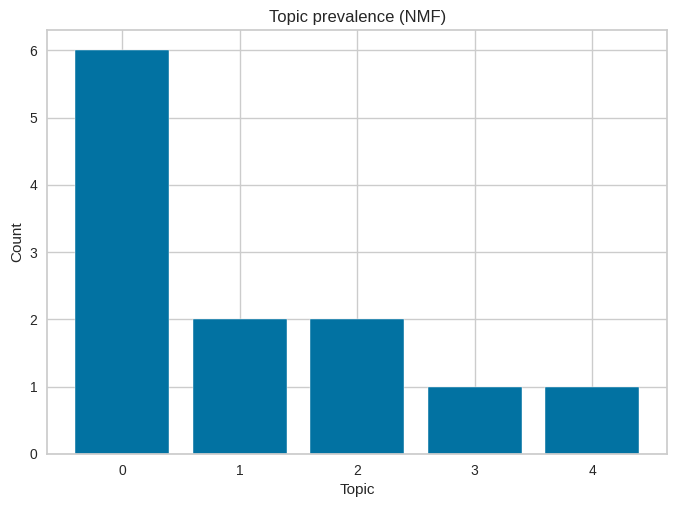

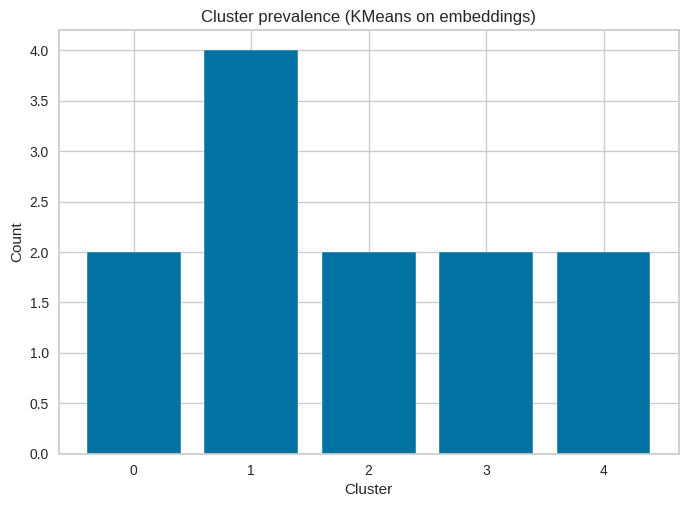

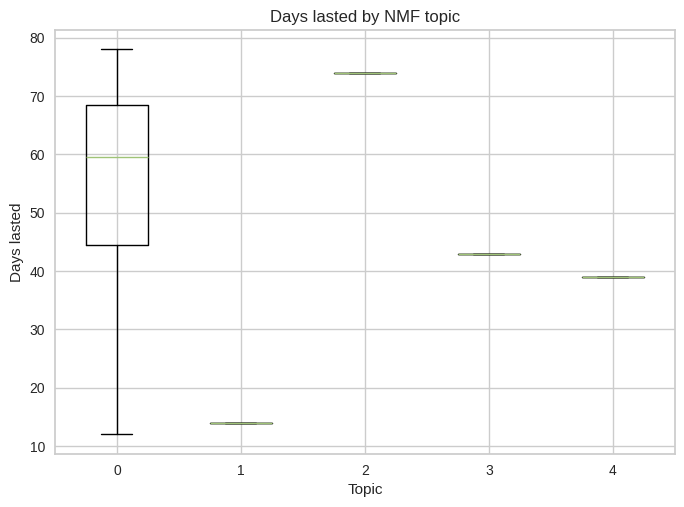

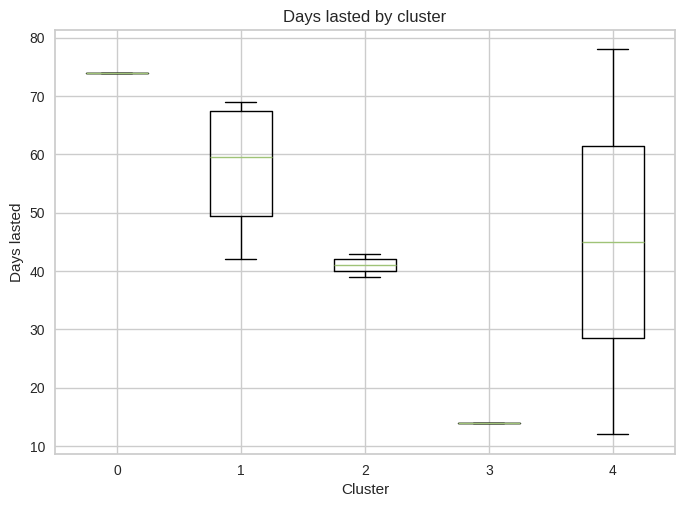

In [ ]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")

    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\b\w+\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^a-z0-9\s']", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH


# this will attach assignments back to df rows used in modeling
mask = (~df["is_short"]) & (df["tap_clean"].notna())
df_model = df.loc[mask].copy()
df_model["topic_nmf"] = topic_assign
df_model["cluster"] = cluster_labels

# the theme prevalence plots
topic_counts = df_model["topic_nmf"].value_counts().sort_index()
plt.figure()
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.title("Topic prevalence (NMF)")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

cluster_counts = df_model["cluster"].value_counts().sort_index()
plt.figure()
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title("Cluster prevalence (KMeans on embeddings)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# these are the days lasted by topic/cluster
if DAYS_COL is not None and DAYS_COL in df_model.columns:
    # By topic
    groups = [df_model.loc[df_model["topic_nmf"]==t, DAYS_COL].dropna().values for t in sorted(df_model["topic_nmf"].unique())]
    plt.figure()
    plt.boxplot(groups, tick_labels=[str(t) for t in sorted(df_model["topic_nmf"].unique())])
    plt.title("Days lasted by NMF topic")
    plt.xlabel("Topic")
    plt.ylabel("Days lasted")
    plt.show()

    # sort by cluster
    groups = [df_model.loc[df_model["cluster"]==c, DAYS_COL].dropna().values for c in sorted(df_model["cluster"].unique())]
    plt.figure()
    plt.boxplot(groups, tick_labels=[str(c) for c in sorted(df_model["cluster"].unique())])
    plt.title("Days lasted by cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Days lasted")
    plt.show()
else:
    print("No days-lasted column available/detected; set DAYS_COL manually if you have it.")

---
## G. Survival Item Association Rules

**Research Question:** Which survival items are chosen together most frequently? Do certain item combinations correlate with better outcomes?

This section applies the Apriori algorithm to discover frequent itemsets and association rules across contestants' gear selections. It integrates with the loadout EDA and supports gear-strategy insights.


In [ ]:
import warnings
warnings.filterwarnings( "ignore", message="datetime\\.datetime\\.utcnow\\(\\) is deprecated",category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Use the shared loadouts_data loaded in Section 1
df = loadouts_data.copy()

### G.1 Data Preprocessing


In [ ]:
# Standardize column names
def standardize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    return df

loadouts = standardize_columns(loadouts_data)
survivalists = standardize_columns(survivalists_data)

# Merge loadouts with contestant outcomes for later interpretation
df = loadouts.merge(
    survivalists[['season','name','days_lasted','medically_evacuated','reason_category','gender','age']],
    on=['season','name'],
    how='left'
)

print("Merged data shape:", df.shape)
print("\nMissing values:")
print(df.isna().mean().sort_values(ascending=False).head())

Merged data shape: (940, 11)

Missing values:
reason_category    0.106383
season             0.000000
version            0.000000
name               0.000000
item_number        0.000000
dtype: float64


In [ ]:
# Create basket format (binary matrix)
# Each row = one contestant's loadout
# Each column = one item type
# Values = 1 if item present, 0 if not

basket = (df.assign(val=1)
            .pivot_table(index=['season','name'],
                        columns='item',
                        values='val',
                        aggfunc='max',
                        fill_value=0))

print("Basket dimensions:", basket.shape)
print(f"Number of contestants: {basket.shape[0]}")
print(f"Number of unique items: {basket.shape[1]}")
print("\nBasket preview:")
display(basket.head(10))

Basket dimensions: (94, 27)
Number of contestants: 94
Number of unique items: 27

Basket preview:


item                     Axe  Bivy bag  Bow and arrows  Canteen  Ferro rod  \
season name                                                                  
1      Alan Kay            1         0               0        1          1   
       Brant McGee         1         0               1        0          1   
       Chris Weatherman    1         0               1        1          1   
       Dustin Feher        1         0               0        1          1   
       Joe Robinet         1         0               0        0          1   
       Josh Chavez         1         0               1        0          1   
       Lucas Miller        1         0               0        0          1   
       Mitch Mitchell      1         1               1        0          1   
       Sam Larson          1         0               1        0          1   
       Wayne Russell       1         0               0        0          1   

item                     Fishing gear  Frying pan  Gillnet  Ground sheet  \
season name                                                                
1      Alan Kay                     1           0        1             0   
       Brant McGee                  1           0        0             0   
       Chris Weatherman             1           0        0             0   
       Dustin Feher                 1           0        1             0   
       Joe Robinet                  1           0        1             0   
       Josh Chavez                  1           0        0             1   
       Lucas Miller                 1           0        0             0   
       Mitch Mitchell               1           0        1             0   
       Sam Larson                   1           0        0             0   
       Wayne Russell                1           0        0             1   

item                     Hammock  ...  Saw  Scotch eyed auger  \
season name                       ...                           
1      Alan Kay                0  ...    1                  0   
       Brant McGee             0  ...    0                  0   
       Chris Weatherman        0  ...    1                  0   
       Dustin Feher            0  ...    0                  0   
       Joe Robinet             0  ...    0                  0   
       Josh Chavez             0  ...    1                  0   
       Lucas Miller            0  ...    1                  0   
       Mitch Mitchell          0  ...    0                  0   
       Sam Larson              0  ...    0                  0   
       Wayne Russell           0  ...    1                  0   

item                     Sharpening stone  Shovel  Sleeping bag  Slingshot  \
season name                                                                  
1      Alan Kay                         0       0             1          0   
       Brant McGee                      0       0             1          0   
       Chris Weatherman                 1       0             1          0   
       Dustin Feher                     0       0             1          1   
       Joe Robinet                      0       0             1          0   
       Josh Chavez                      0       0             1          0   
       Lucas Miller                     0       0             1          0   
       Mitch Mitchell                   1       0             1          0   
       Sam Larson                       0       0             1          1   
       Wayne Russell                    0       0             1          0   

item                     Soap  Tarp  Trapping wire  Wire  
season name                                               
1      Alan Kay             0     0              0     1  
       Brant McGee          0     1              0     0  
       Chris Weatherman     0     0              0     0  
       Dustin Feher         0     0              0     0  
       Joe Robinet          0     1              0     0  
       Josh Chavez 

### G.2 Basket Format Creation


In [ ]:
basket = (df.assign(val=1)
            .pivot_table(index=['season','name'], columns='item', values='val', aggfunc='max', fill_value=0))

# Attach outcomes for later interpretation
outcomes = (survivalists.set_index(['season','name'])
            [['days_lasted','medically_evacuated','reason_category','gender','age']])

X = basket.join(outcomes, how='left')


### G.3 EDA: Item Frequencies


In [ ]:
# Calculate item frequencies
item_freq = basket.sum(axis=0).sort_values(ascending=False)
item_pct = (item_freq / len(basket) * 100).round(2)

freq_df = pd.DataFrame({
    'item': item_freq.index,
    'count': item_freq.values,
    'percent': item_pct.values
})

print("Top 10 Most Popular Items:")
display(freq_df.head(10))

print("\nBottom 10 Least Popular Items:")
display(freq_df.tail(10))

Top 10 Most Popular Items:


,item,count,percent
0,Fishing gear,90,95.74
1,Pot,90,95.74
2,Sleeping bag,82,87.23
3,Axe,80,85.11
4,Saw,78,82.98
5,Ferro rod,77,81.91
6,Bow and arrows,60,63.83
7,Paracord,56,59.57
8,Rations,55,58.51
9,Knife,50,53.19



Bottom 10 Least Popular Items:


,item,count,percent
17,Sharpening stone,4,4.26
18,Wire,3,3.19
19,Slingshot,3,3.19
20,Ground sheet,2,2.13
21,Hammock,2,2.13
22,Salt,2,2.13
23,Soap,2,2.13
24,Rope,1,1.06
25,Scotch eyed auger,1,1.06
26,Shovel,1,1.06


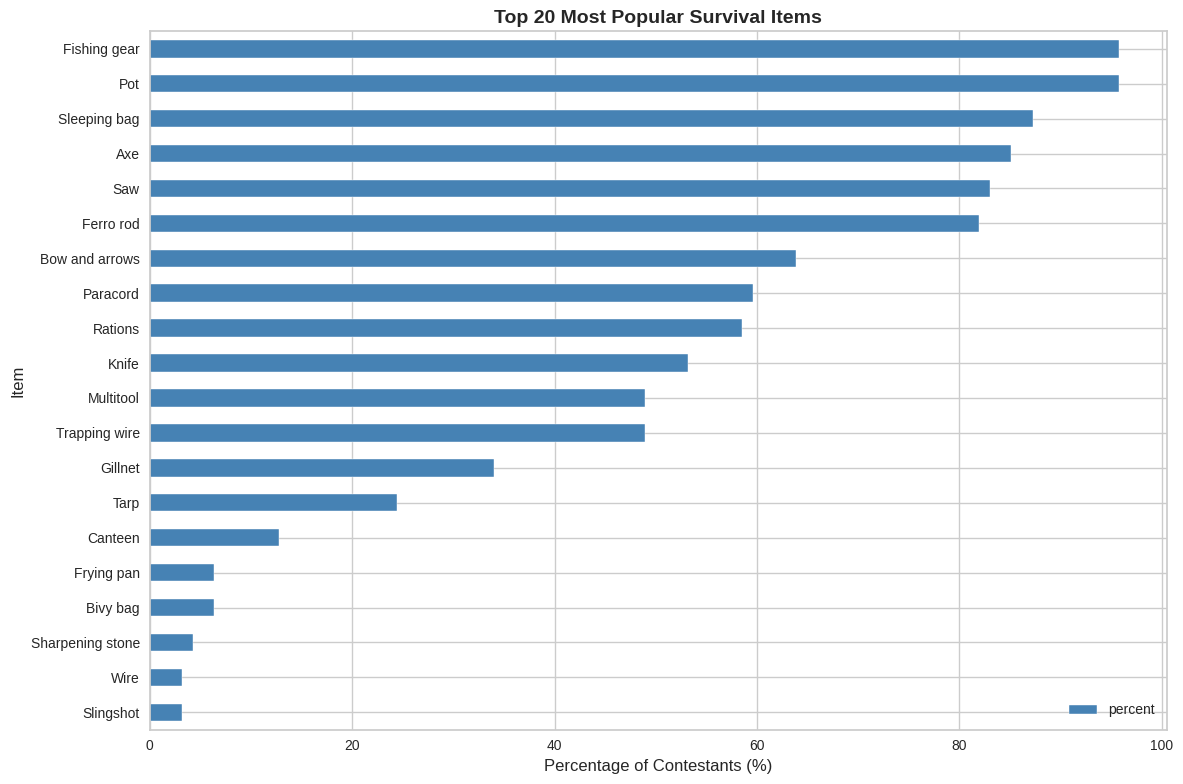

In [ ]:
# Visualizing this
fig, ax = plt.subplots(figsize=(12, 8))
freq_df.head(20).plot(x='item', y='percent', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Percentage of Contestants (%)', fontsize=12)
ax.set_ylabel('Item', fontsize=12)
ax.set_title('Top 20 Most Popular Survival Items', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### G.4 Apriori Algorithm


**Threshold rationale:**
1. **Low (0.10):** Captures rare but potentially interesting combinations.
2. **Medium (0.20):** Balanced view of moderately common patterns.
3. **High (0.30):** Only very common, core strategies.


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apriori with low minimum support
frequent_itemsets_low = apriori(basket, min_support=0.10, use_colnames=True)
frequent_itemsets_low['length'] = frequent_itemsets_low['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_low)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_low.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_low.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 2068

Itemsets by size:
length
1      15
2      89
3     272
4     499
5     564
6     393
7     174
8      51
9      10
10      1
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
9,0.957447,(Pot),1
4,0.957447,(Fishing gear),1
57,0.925532,"(Pot, Fishing gear)",2
12,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
92,0.829787,"(Pot, Sleeping bag)",2
60,0.829787,"(Sleeping bag, Fishing gear)",2
11,0.829787,(Saw),1
51,0.819149,"(Ferro rod, Sleeping bag)",2
17,0.819149,"(Fishing gear, Axe)",2


In [ ]:
# Apriori with medium minimum support
frequent_itemsets_med = apriori(basket, min_support=0.20, use_colnames=True)
frequent_itemsets_med['length'] = frequent_itemsets_med['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_med)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_med.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_med.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 1176

Itemsets by size:
length
1     14
2     76
3    204
4    324
5    321
6    183
7     50
8      4
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
3,0.957447,(Fishing gear),1
8,0.957447,(Pot),1
51,0.925532,"(Pot, Fishing gear)",2
11,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
54,0.829787,"(Sleeping bag, Fishing gear)",2
80,0.829787,"(Pot, Sleeping bag)",2
10,0.829787,(Saw),1
16,0.819149,"(Fishing gear, Axe)",2
2,0.819149,(Ferro rod),1


In [ ]:
# Apriori with high minimum support (0.30)
frequent_itemsets_high = apriori(basket, min_support=0.30, use_colnames=True)
frequent_itemsets_high['length'] = frequent_itemsets_high['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_high)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_high.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_high.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 494

Itemsets by size:
length
1     13
2     62
3    145
4    166
5     91
6     17
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
3,0.957447,(Fishing gear),1
8,0.957447,(Pot),1
47,0.925532,"(Pot, Fishing gear)",2
11,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
68,0.829787,"(Pot, Sleeping bag)",2
50,0.829787,"(Sleeping bag, Fishing gear)",2
10,0.829787,(Saw),1
2,0.819149,(Ferro rod),1
41,0.819149,"(Ferro rod, Sleeping bag)",2


### G.5 Association Rules


In [ ]:
# Generate association rules from medium support itemsets
rules = association_rules(frequent_itemsets_med, metric="confidence",min_threshold=0.7)

# Filter by lift > 1.0
rules = rules[rules['lift'] > 1.2]

# Sort by lift (descending)
rules = rules.sort_values('lift', ascending=False)

print(f"Total rules generated: {len(rules)}")
print(f"\nRule metrics summary:")
print(rules[['support', 'confidence', 'lift']].describe())

Total rules generated: 2720

Rule metrics summary:
           support   confidence         lift
count  2720.000000  2720.000000  2720.000000
mean      0.250962     0.783592     1.487212
std       0.040022     0.066889     0.208231
min       0.202128     0.700000     1.200269
25%       0.212766     0.730769     1.320562
50%       0.244681     0.769231     1.450617
75%       0.276596     0.821429     1.631152
max       0.446809     1.000000     2.160920


In [ ]:
print("Top 15 Association Rules (by Lift)")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

Top 15 Association Rules (by Lift)


,antecedents,consequents,support,confidence,lift
10009,"(Multitool, Fishing gear, Ferro rod, Bow and a...","(Pot, Sleeping bag, Trapping wire, Axe)",0.234043,0.758621,2.160920
9980,"(Pot, Fishing gear, Ferro rod, Trapping wire, ...","(Multitool, Sleeping bag, Bow and arrows)",0.234043,0.733333,2.154167
10010,"(Multitool, Sleeping bag, Fishing gear, Bow an...","(Pot, Trapping wire, Ferro rod, Axe)",0.234043,0.733333,2.154167
10028,"(Multitool, Ferro rod, Bow and arrows)","(Pot, Fishing gear, Sleeping bag, Trapping wir...",0.234043,0.709677,2.151925
9981,"(Pot, Fishing gear, Sleeping bag, Trapping wir...","(Multitool, Ferro rod, Bow and arrows)",0.234043,0.709677,2.151925
8492,"(Multitool, Fishing gear, Ferro rod, Bow and a...","(Sleeping bag, Trapping wire, Axe)",0.244681,0.793103,2.130049
8493,"(Multitool, Sleeping bag, Fishing gear, Bow an...","(Ferro rod, Trapping wire, Axe)",0.244681,0.766667,2.119608
8515,"(Multitool, Ferro rod, Bow and arrows)","(Sleeping bag, Fishing gear, Trapping wire, Axe)",0.244681,0.741935,2.113392
8853,"(Multitool, Ferro rod, Bow and arrows)","(Pot, Sleeping bag, Trapping wire, Axe)",0.244681,0.741935,2.113392
8854,"(Multitool, Sleeping bag, Bow and arrows)","(Pot, Trapping wire, Ferro rod, Axe)",0.244681,0.718750,2.111328


### G.6 Visualization of Rules

**What we did:** Generated rules and visualized support, confidence, and lift.

**What the output shows:** The scatter plot and table above highlight rules with high lift, indicating items that tend to be chosen together more often than expected by chance.

**Why it matters:** These patterns inform gear recommendations and strategic loadout design.


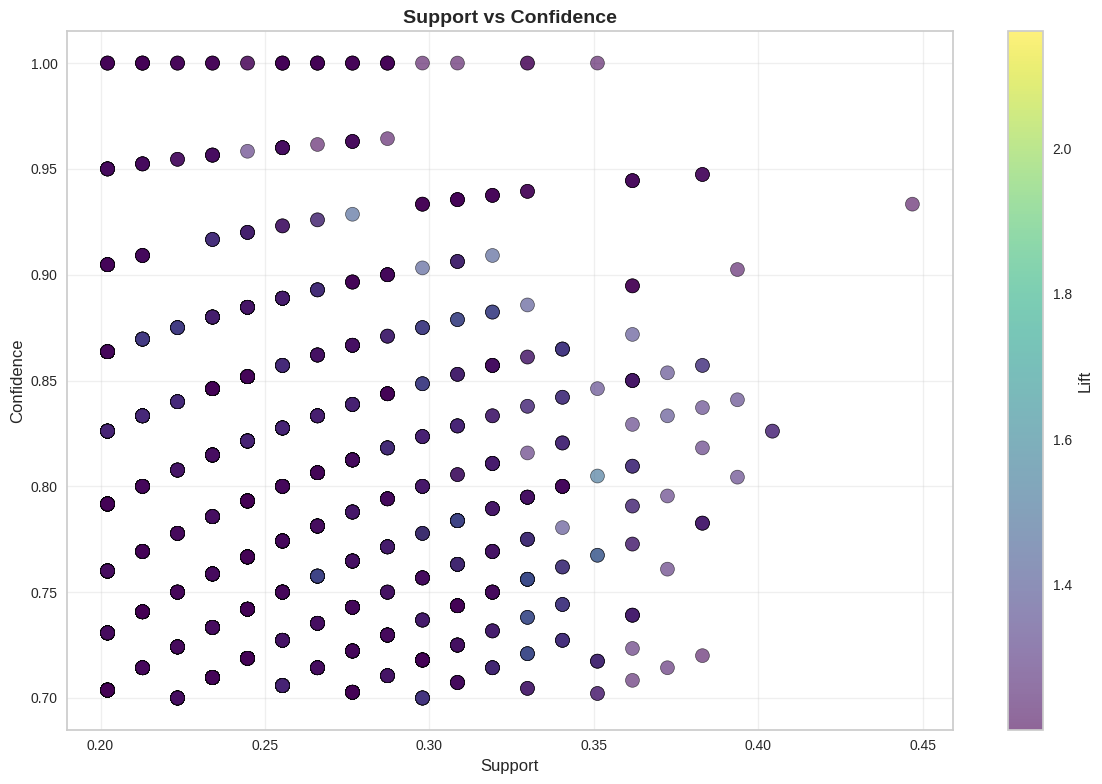

In [ ]:
# Scatter plot: Support vs Confidence, colored by Lift
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(rules['support'], rules['confidence'], c=rules['lift'], s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Support vs Confidence',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12)

plt.tight_layout()
plt.show()

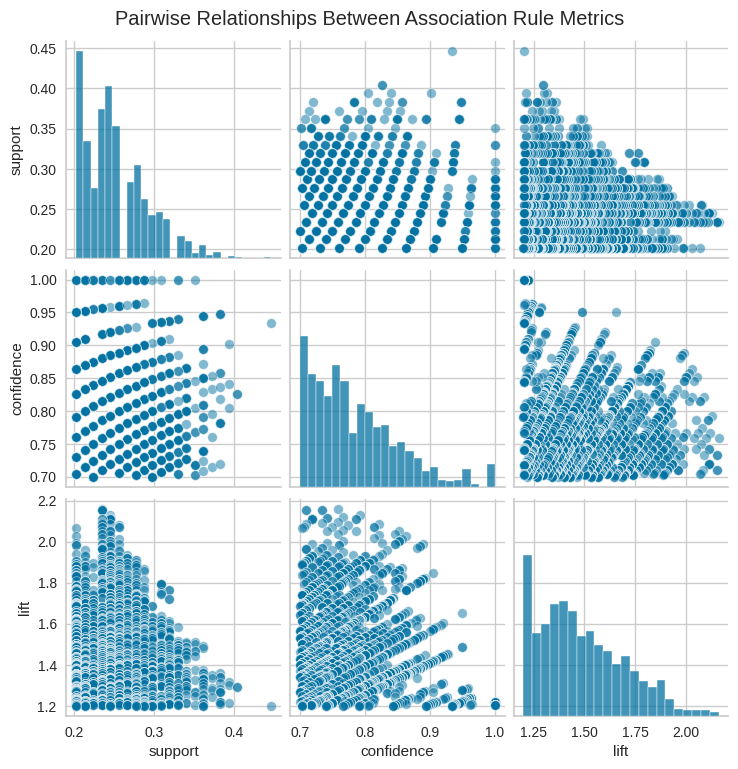

In [ ]:
metrics = rules[['support', 'confidence', 'lift']]
metrics_sample = metrics[(rules['lift'] >= 1.2) & (rules['support'] >= 0.15)]

sns.pairplot(metrics_sample, diag_kind='hist', plot_kws={'alpha': 0.5})

plt.suptitle("Pairwise Relationships Between Association Rule Metrics", y=1.02)
plt.show()